# 🏥 Multi-Label OOD Detection in Medical Imaging
## Explainable and Trustworthy AI - Project 1

### 📋 Obiettivo del Progetto
Sviluppare un sistema che rilevi quando un'immagine medica contiene **SIA** malattie conosciute **CHE** malattie sconosciute (mai viste durante il training).

**Il problema clinico:** Un modello addestrato su 13 malattie polmonari incontra un paziente con Pneumothorax (mai visto) + Polmonite (vista in training). I metodi attuali vedono solo la Polmonite e ignorano il Pneumothorax!

### 🎯 Il nostro contributo
Creare un metodo che superi questa limitazione e dica: "Vedo la Polmonite MA c'è anche qualcosa di anomalo che richiede attenzione medica"

---

### ⚠️ NOTA IMPORTANTE SUL DATASET
- **Dataset completo ChestX-ray14**: ~45GB (richiede ~60GB totali di spazio)
- **Questo notebook usa un subset**: ~5-7GB (compatibile con account Google gratuito 15GB)
- Per risultati di ricerca completi, considerate di usare il dataset intero su Colab Pro o server universitario

## 📦 STEP 1: Setup Environment e Import Dataset


In [1]:
# ────── Cell 1: Installa PyTorch + altre librerie ──────
# forza reinstall senza toccare le dipendenze (evita downgrade di numpy, tensorflow ecc)
# !pip install --upgrade --force-reinstall \
#     torch torchvision torchaudio \
#     --extra-index-url https://download.pytorch.org/whl/cu121 \
#     --no-deps --quiet

# # installa tutte le altre librerie di supporto
# !pip install kaggle pandas matplotlib seaborn scikit-learn grad-cam tqdm Pillow --quiet


In [2]:

# ✅ Import librerie
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# ⚙️ Verifica GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

import torch
import torchvision
import numpy as np

print("\n--- Version Check ---")
print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("NumPy version:", np.__version__)
print("CUDA disponibile:", torch.cuda.is_available())

Using device: cuda
GPU: NVIDIA RTX 500 Ada Generation Laptop GPU

--- Version Check ---
Torch version: 2.7.1+cu118
Torchvision version: 0.22.1+cu118
NumPy version: 2.3.1
CUDA disponibile: True


### 📥 Download Dataset Subset


In [3]:
# TROVA E ORGANIZZA LE IMMAGINI DEL DATASET
import os
import shutil
from pathlib import Path
from tqdm import tqdm
import pandas as pd

print("🔍 RICERCA IMMAGINI ChestX-ray14")
print("=" * 50)

# Directory da controllare
search_paths = [
    Path.home() / 'Downloads' / 'archive',
    Path.home() / 'Downloads',
    Path('./data'),
    Path('.')
]

print("📁 Percorsi di ricerca:")
for path in search_paths:
    print(f"   {path}")

# STEP 1: CERCA CARTELLE CON IMMAGINI
print(f"\n🔍 STEP 1: RICERCA CARTELLE IMMAGINI")
print("-" * 40)

found_image_folders = []
found_image_files = []

for search_path in search_paths:
    if not search_path.exists():
        print(f"❌ {search_path} - Non esiste")
        continue
    
    print(f"🔎 Cercando in: {search_path}")
    
    # Cerca cartelle images_XXX
    image_folders = list(search_path.glob('images_*'))
    if image_folders:
        print(f"   📁 Trovate {len(image_folders)} cartelle images_*:")
        for folder in image_folders:
            # Cerca PNG direttamente nella cartella
            png_count = len(list(folder.glob('*.png')))
            if png_count > 0:
                found_image_folders.append(folder)
                print(f"      {folder.name}: {png_count:,} immagini")
            else:
                # Cerca PNG in sottocartella images/
                subfolder = folder / 'images'
                if subfolder.exists():
                    png_count = len(list(subfolder.glob('*.png')))
                    if png_count > 0:
                        found_image_folders.append(subfolder)  # ← Usa la sottocartella
                        print(f"      {folder.name}/images/: {png_count:,} immagini")
                    else:
                        print(f"      {folder.name}: vuota")
    
    # Cerca cartella images singola
    images_folder = search_path / 'images'
    if images_folder.exists():
        png_count = len(list(images_folder.glob('*.png')))
        if png_count > 0:
            found_image_files.append(images_folder)
            print(f"   📁 Cartella images/: {png_count:,} immagini")
    
    # Cerca immagini PNG sparse
    png_files = list(search_path.glob('*.png'))
    if png_files:
        print(f"   📄 File PNG diretti: {len(png_files)}")
        if len(png_files) > 1000:  # Probabilmente il dataset
            found_image_files.append(search_path)

print(f"\n📊 RISULTATI RICERCA:")
print(f"   Cartelle images_*: {len(found_image_folders)}")
print(f"   Cartelle/directory con PNG: {len(found_image_files)}")

# STEP 2: SCELTA AUTOMATICA DELLA MIGLIORE FONTE
print(f"\n🎯 STEP 2: SELEZIONE FONTE IMMAGINI")
print("-" * 40)

source_folders = []
total_images_available = 0

# Priorità alle cartelle images_* (dataset originale)
if found_image_folders:
    print("✅ Usando cartelle images_* (dataset originale)")
    source_folders = found_image_folders
    for folder in found_image_folders:
        count = len(list(folder.glob('*.png')))
        total_images_available += count
        print(f"   {folder}: {count:,} immagini")

elif found_image_files:
    print("✅ Usando cartella images esistente")
    # Prendi la cartella con più immagini
    best_folder = max(found_image_files, key=lambda x: len(list(x.glob('*.png'))))
    source_folders = [best_folder]
    total_images_available = len(list(best_folder.glob('*.png')))
    print(f"   {best_folder}: {total_images_available:,} immagini")

else:
    print("❌ NESSUNA IMMAGINE TROVATA!")
    print("\n💡 Possibili soluzioni:")
    print("   1. Controlla che il download sia completato")
    print("   2. Verifica la posizione del file estratto")
    print("   3. Cerca manualmente cartelle images_* o file PNG")
    
    # Mostra contenuto Downloads per debug
    downloads = Path.home() / 'Downloads'
    if downloads.exists():
        print(f"\n📂 Contenuto Downloads:")
        for item in downloads.iterdir():
            if item.is_dir():
                print(f"   📁 {item.name}/")
            elif item.suffix in ['.zip', '.rar', '.tar']:
                print(f"   📦 {item.name}")
    
    raise FileNotFoundError("Immagini non trovate!")

print(f"\n📊 Totale immagini disponibili: {total_images_available:,}")

# STEP 3: ORGANIZZA IMMAGINI
if total_images_available > 0:
    print(f"\n📦 STEP 3: ORGANIZZAZIONE IMMAGINI")
    print("-" * 40)
    
    # Crea directory di destinazione
    data_dir = Path('./data')
    images_dir = data_dir / 'images'
    images_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"📁 Directory destinazione: {images_dir}")
    
    # Conta immagini già presenti
    existing_images = len(list(images_dir.glob('*.png')))
    print(f"🔢 Immagini già presenti: {existing_images:,}")
    
    if existing_images < total_images_available * 0.9:  # Se mancano >10% delle immagini
        print("🚀 Copiando immagini...")
        
        copied_count = 0
        skipped_count = 0
        
        # Copia da tutte le cartelle fonte
        for source_folder in tqdm(source_folders, desc="Cartelle"):
            png_files = list(source_folder.glob('*.png'))
            
            for png_file in tqdm(png_files, desc=f"Copiando {source_folder.name}", leave=False):
                dst_path = images_dir / png_file.name
                
                if not dst_path.exists():
                    try:
                        shutil.copy2(png_file, dst_path)
                        copied_count += 1
                    except Exception as e:
                        print(f"⚠️ Errore copiando {png_file.name}: {e}")
                else:
                    skipped_count += 1
        
        print(f"✅ Copiaggio completato:")
        print(f"   📋 Copiate: {copied_count:,} immagini")
        print(f"   ⏭️ Saltate (già presenti): {skipped_count:,}")
        
    else:
        print("✅ Immagini già organizzate correttamente")

# STEP 4: VERIFICA FINALE E CARICAMENTO
print(f"\n📊 STEP 4: VERIFICA E CARICAMENTO")
print("-" * 40)

# Verifica directory finale
images_dir = data_dir / 'images'
final_png_count = len(list(images_dir.glob('*.png')))
print(f"🖼️ Immagini finali in data/images/: {final_png_count:,}")

# Carica CSV
csv_path = data_dir / 'Data_Entry_2017_v2020.csv'
if csv_path.exists():
    print(f"📋 Caricando CSV...")
    data_entry = pd.read_csv(csv_path)
    print(f"✅ CSV caricato: {len(data_entry):,} righe")
    
    # Filtra per immagini esistenti
    available_images = {f.name for f in images_dir.glob('*.png')}
    initial_rows = len(data_entry)
    data_entry = data_entry[data_entry['Image Index'].isin(available_images)]
    final_rows = len(data_entry)
    
    print(f"🔄 DataFrame filtrato: {initial_rows:,} → {final_rows:,} righe")
    print(f"📈 Coverage: {(final_rows/initial_rows)*100:.1f}%")
    
    # Analisi Pneumothorax
    pneumo_cases = data_entry[data_entry['Finding Labels'].str.contains('Pneumothorax', na=False)]
    print(f"🎯 Casi Pneumothorax: {len(pneumo_cases):,}")
    
    print(f"\n🎉 DATASET PRONTO!")
    print(f"✅ Variable 'data_entry': {len(data_entry):,} righe")
    print(f"✅ Directory immagini: {images_dir}")
    print(f"✅ Pronto per l'analisi!")

else:
    print(f"❌ CSV non trovato: {csv_path}")

🔍 RICERCA IMMAGINI ChestX-ray14
📁 Percorsi di ricerca:
   C:\Users\MRLSML00A\Downloads\archive
   C:\Users\MRLSML00A\Downloads
   data
   .

🔍 STEP 1: RICERCA CARTELLE IMMAGINI
----------------------------------------
❌ C:\Users\MRLSML00A\Downloads\archive - Non esiste
🔎 Cercando in: C:\Users\MRLSML00A\Downloads
🔎 Cercando in: data
   📁 Trovate 12 cartelle images_*:
      images_001/images/: 4,999 immagini
      images_002/images/: 10,000 immagini
      images_003/images/: 10,000 immagini
      images_004/images/: 10,000 immagini
      images_005/images/: 10,000 immagini
      images_006/images/: 10,000 immagini
      images_007/images/: 10,000 immagini
      images_008/images/: 10,000 immagini
      images_009/images/: 10,000 immagini
      images_010/images/: 10,000 immagini
      images_011/images/: 10,000 immagini
      images_012/images/: 7,121 immagini
   📁 Cartella images/: 112,120 immagini
🔎 Cercando in: .

📊 RISULTATI RICERCA:
   Cartelle images_*: 12
   Cartelle/directory con

## 🔍 STEP 2: Esplorazione e Comprensione del Dataset

### Cosa dobbiamo capire:
1. **Struttura multi-label**: ogni immagine può avere 0-14 malattie
2. **Distribuzione malattie**: quali sono comuni/rare
3. **Co-occorrenze**: quali malattie appaiono spesso insieme (importante per il nostro metodo!)
4. **Identificare casi "ibridi"**: immagini con multiple malattie

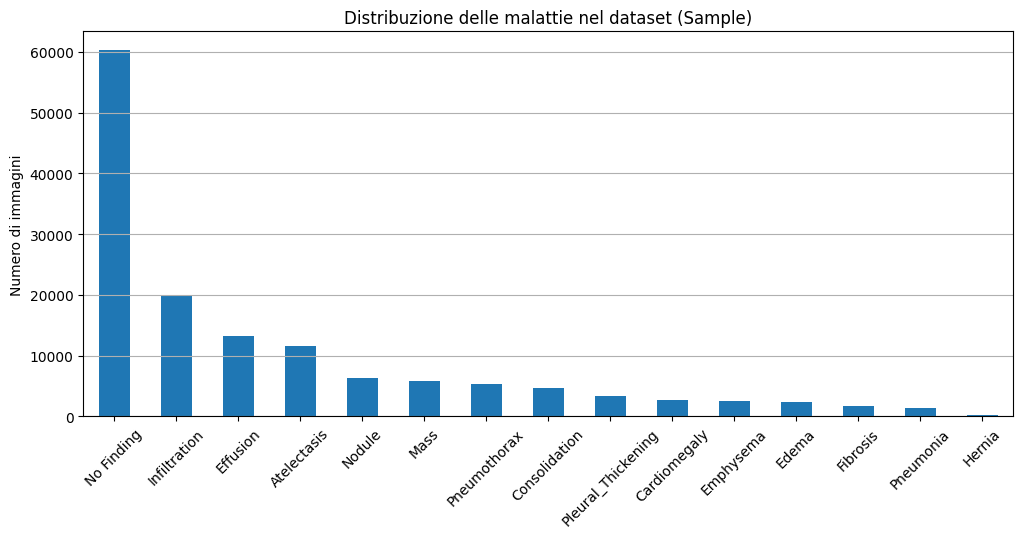

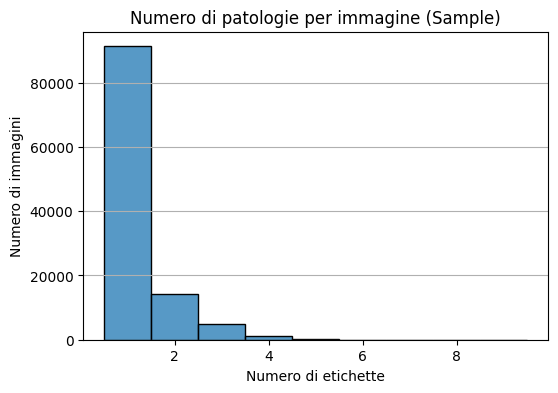

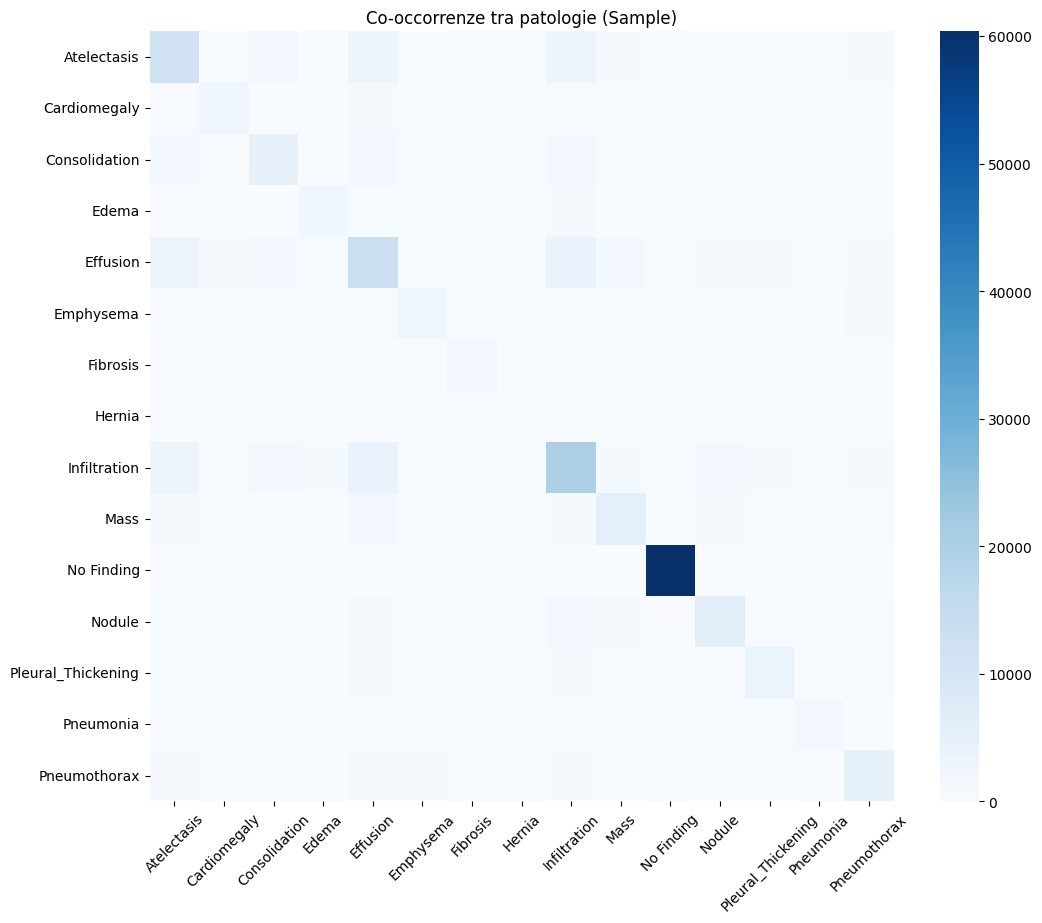

Totale immagini con Pneumothorax: 5302
→ solo Pneumothorax (OOD puro): 2194
→ Pneumothorax + altre (OOD misto): 3108

Co-occorrenze più frequenti con Pneumothorax:
- Effusion: 996 immagini
- Infiltration: 946 immagini
- Atelectasis: 774 immagini
- Emphysema: 747 immagini
- Mass: 431 immagini


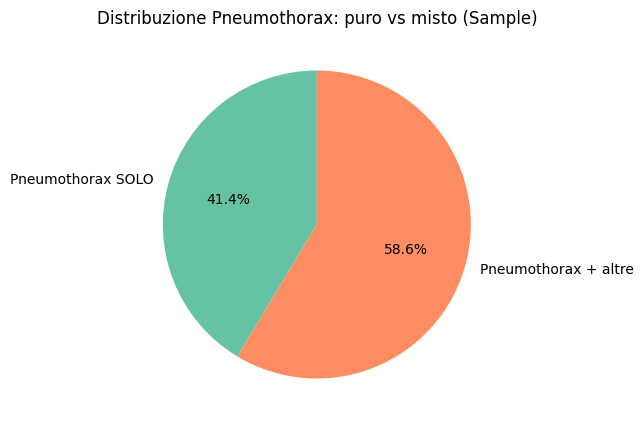

In [4]:
# Usiamo il DataFrame 'data_entry' già filtrato con le immagini disponibili
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')

# 1. Analizza distribuzione delle malattie
all_labels = data_entry['Finding Labels'].str.split('|').explode()
label_counts = Counter(all_labels)

plt.figure(figsize=(12, 5))
pd.Series(label_counts).sort_values(ascending=False).plot(kind='bar')
plt.title('Distribuzione delle malattie nel dataset (Sample)')
plt.ylabel('Numero di immagini')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# 2. Quante immagini hanno malattie multiple?
data_entry['num_labels'] = data_entry['Finding Labels'].str.count('\|') + 1

plt.figure(figsize=(6, 4))
sns.histplot(data_entry['num_labels'], bins=range(1, 7), discrete=True)
plt.title('Numero di patologie per immagine (Sample)')
plt.xlabel('Numero di etichette')
plt.ylabel('Numero di immagini')
plt.grid(axis='y')
plt.show()

# 3. Identifica co-occorrenze comuni
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
label_matrix = mlb.fit_transform(data_entry['Finding Labels'].str.split('|'))
label_df = pd.DataFrame(label_matrix, columns=mlb.classes_)
cooc_matrix = label_df.T @ label_df

plt.figure(figsize=(12, 10))
sns.heatmap(cooc_matrix, annot=False, fmt='d', cmap='Blues')
plt.title('Co-occorrenze tra patologie (Sample)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# 4. Focus su Pneumothorax:
pneumo_mask = data_entry['Finding Labels'].str.contains('Pneumothorax')
pneumo_data = data_entry[pneumo_mask]
pneumo_puro = pneumo_data[pneumo_data['Finding Labels'] == 'Pneumothorax']
pneumo_misto = pneumo_data[pneumo_data['Finding Labels'].str.contains('\|')]
co_labels = pneumo_misto['Finding Labels'].str.split('|').explode()
co_labels = co_labels[co_labels != 'Pneumothorax']
co_counts = Counter(co_labels)

print(f"Totale immagini con Pneumothorax: {len(pneumo_data)}")
print(f"→ solo Pneumothorax (OOD puro): {len(pneumo_puro)}")
print(f"→ Pneumothorax + altre (OOD misto): {len(pneumo_misto)}\n")

print("Co-occorrenze più frequenti con Pneumothorax:")
for label, count in co_counts.most_common(5):
    print(f"- {label}: {count} immagini")

# Pie chart
plt.figure(figsize=(5, 5))
if len(pneumo_puro) > 0 or len(pneumo_misto) > 0:
    plt.pie(
        [len(pneumo_puro), len(pneumo_misto)],
        labels=['Pneumothorax SOLO', 'Pneumothorax + altre'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#66c2a5', '#fc8d62']
    )
    plt.title('Distribuzione Pneumothorax: puro vs misto (Sample)')
else:
    plt.text(0.5, 0.5, 'No Pneumothorax cases\nin this sample',
             horizontalalignment='center', verticalalignment='center')
    plt.title('Nessun caso di Pneumothorax nel sample')
plt.show()

## 🎯 STEP 3: Setup Esperimento OOD

### Piano sperimentale:
1. **Malattia OOD**: Pneumothorax (fingeremo che sia "sconosciuta")
2. **Malattie conosciute**: tutte le altre 13
3. **Divisione dati** (dal nostro sample set filtrato):
   - **Training set**: solo immagini SENZA Pneumothorax
   - **Test ID**: immagini senza Pneumothorax
   - **Test OOD puro**: immagini con SOLO Pneumothorax
   - **Test OOD misto**: immagini con Pneumothorax + altre malattie ⚠️ (il caso difficile!)

In [5]:
from sklearn.model_selection import train_test_split

# Definisci le classi
ALL_DISEASES = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
                'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation',
                'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

OOD_DISEASE = 'Pneumothorax'
KNOWN_DISEASES = [d for d in ALL_DISEASES if d != OOD_DISEASE]

#  1. Separa immagini con e senza Pneumothorax dal nostro DataFrame 'data_entry' già filtrato
no_pneumo_data = data_entry[~data_entry['Finding Labels'].str.contains(OOD_DISEASE)]
pneumo_data = data_entry[data_entry['Finding Labels'].str.contains(OOD_DISEASE)]

#  2. Split immagini senza Pneumothorax in train e test ID
train_data, test_id_data = train_test_split(no_pneumo_data, test_size=0.3, random_state=42, shuffle=True)

#  3. Identifica OOD puro (solo Pneumothorax)
test_ood_pure = pneumo_data[pneumo_data['Finding Labels'] == OOD_DISEASE]

#  4. Identifica OOD misto (Pneumothorax + altre malattie)
test_ood_mixed = pneumo_data[pneumo_data['Finding Labels'].str.contains('\|')]

#  5. Statistiche di controllo
print("--- Dataset Splits ---")
print(f"Train: {len(train_data)} immagini (no {OOD_DISEASE})")
print(f"Test ID: {len(test_id_data)} immagini (no {OOD_DISEASE})")
print(f"Test OOD Pure: {len(test_ood_pure)} immagini (solo {OOD_DISEASE})")
print(f"Test OOD Mixed: {len(test_ood_mixed)} immagini ({OOD_DISEASE} + altre)")

# FIX SBILANCIAMENTO
print("\n" + "="*50)
print("🎯 FIXING TRAINING SET IMBALANCE")
print("="*50)

def balance_training_data(df):
    print(f"📊 Original training set: {len(df)} samples")

    no_finding = df[df['Finding Labels'] == 'No Finding']
    with_disease = df[df['Finding Labels'] != 'No Finding']

    print(f"- No Finding: {len(no_finding)} ({len(no_finding)/len(df)*100:.1f}%)")
    print(f"- With Disease: {len(with_disease)} ({len(with_disease)/len(df)*100:.1f}%)")

    # Riduci "No Finding" a massimo il doppio delle immagini con patologie
    if len(no_finding) > len(with_disease) * 2:
        target_no_finding = len(with_disease) * 2
        no_finding_reduced = no_finding.sample(n=target_no_finding, random_state=42)
        balanced_data = pd.concat([with_disease, no_finding_reduced]).sample(frac=1, random_state=42)

        print(f"\n✅ Balanced training set: {len(balanced_data)} samples")
        print(f"- No Finding: {len(no_finding_reduced)} ({len(no_finding_reduced)/len(balanced_data)*100:.1f}%)")
        print(f"- With Disease: {len(with_disease)} ({len(with_disease)/len(balanced_data)*100:.1f}%)")
        return balanced_data.reset_index(drop=True)
    else:
        print("\n✅ Training set già sufficientemente bilanciato.")
        return df.reset_index(drop=True)

print("\n" + "="*50)
print("🎯 BILANCIAMENTO AGGRESSIVO DEL TRAINING SET")
print("="*50)

no_finding = train_data[train_data['Finding Labels'] == 'No Finding']
with_disease = train_data[train_data['Finding Labels'] != 'No Finding']

print(f"- No Finding originali: {len(no_finding)}")
print(f"- With Disease originali: {len(with_disease)}")

# Bilancia 1:1 per training più focalizzato sulle malattie
if len(no_finding) > len(with_disease):
    no_finding_reduced = no_finding.sample(n=len(with_disease), random_state=42)
    train_data = pd.concat([with_disease, no_finding_reduced]).sample(frac=1, random_state=42)
    print(f"✅ Bilanciato 1:1 - Totale: {len(train_data)} samples")

train_data = train_data.reset_index(drop=True)

# Riduci solo se il rapporto è estremo (>5:1 invece di >2:1)
if len(no_finding) > len(with_disease) * 5:
    target_no_finding = len(with_disease) * 5
    no_finding_reduced = no_finding.sample(n=target_no_finding, random_state=42)
    train_data = pd.concat([with_disease, no_finding_reduced]).sample(frac=1, random_state=42)
    print(f"✅ Reduced to: {len(train_data)} samples")
else:
    print("✅ Using ALL data - no reduction needed")

train_data = train_data.reset_index(drop=True)

--- Dataset Splits ---
Train: 74772 immagini (no Pneumothorax)
Test ID: 32046 immagini (no Pneumothorax)
Test OOD Pure: 2194 immagini (solo Pneumothorax)
Test OOD Mixed: 3108 immagini (Pneumothorax + altre)

🎯 FIXING TRAINING SET IMBALANCE

🎯 BILANCIAMENTO AGGRESSIVO DEL TRAINING SET
- No Finding originali: 42304
- With Disease originali: 32468
✅ Bilanciato 1:1 - Totale: 64936 samples
✅ Using ALL data - no reduction needed


## 🏗️ STEP 4: Creazione Dataset e DataLoader

### Implementare:
1. Custom Dataset class per gestire multi-label.
2. **MODIFICA**: La classe non creerà più immagini nere. Se un'immagine non viene trovata, solleverà un errore, il che è desiderabile dato che abbiamo pre-filtrato i dati.
3. Data augmentation appropriata.
4. DataLoader per training e testing.

In [6]:
# STEP 4: CREAZIONE DATASET E DATALOADERS - Versione Completa
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
import numpy as np

print("🏗️ STEP 4: CREAZIONE DATASET E DATALOADERS")
print("=" * 60)

# Verifica prerequisiti
if 'data_entry' not in locals():
    print("❌ ERRORE: Variable 'data_entry' non trovata!")
    print("   Esegui prima il codice di caricamento dataset")
    raise NameError("data_entry not defined")

print(f"✅ Dataset caricato: {len(data_entry):,} immagini")

# ═══════════════════════════════════════════════════════════════
# DEFINIZIONE MALATTIE E SETUP ESPERIMENTO OOD
# ═══════════════════════════════════════════════════════════════

# Definisci tutte le malattie del dataset
ALL_DISEASES = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
                'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation',
                'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

# Malattia OOD (faremo finta che sia "sconosciuta")
OOD_DISEASE = 'Pneumothorax'
KNOWN_DISEASES = [d for d in ALL_DISEASES if d != OOD_DISEASE]

print(f"🎯 Setup Esperimento OOD:")
print(f"  🔴 Malattia OOD (sconosciuta): {OOD_DISEASE}")
print(f"  🟢 Malattie conosciute: {len(KNOWN_DISEASES)} ({', '.join(KNOWN_DISEASES[:5])}...)")

# Directory immagini
img_dir = Path('./data/images')
print(f"📁 Directory immagini: {img_dir}")

# Verifica che la directory esista
if not img_dir.exists():
    print(f"❌ ERRORE: Directory immagini non trovata: {img_dir}")
    print("   Assicurati che la copia delle immagini sia completata")
    raise FileNotFoundError(f"Directory immagini non trovata: {img_dir}")

# Conta immagini disponibili
png_files = list(img_dir.glob('*.png'))
print(f"🖼️ Immagini disponibili: {len(png_files):,}")

# ═══════════════════════════════════════════════════════════════
# SPLIT DATASET PER OOD DETECTION
# ═══════════════════════════════════════════════════════════════

print(f"\n📊 DIVISIONE DATASET PER OOD DETECTION")
print("-" * 50)

# 1. Separa immagini con e senza Pneumothorax
no_pneumo_data = data_entry[~data_entry['Finding Labels'].str.contains(OOD_DISEASE, na=False)]
pneumo_data = data_entry[data_entry['Finding Labels'].str.contains(OOD_DISEASE, na=False)]

print(f"📈 Divisione iniziale:")
print(f"  Senza {OOD_DISEASE}: {len(no_pneumo_data):,} immagini")
print(f"  Con {OOD_DISEASE}: {len(pneumo_data):,} immagini")

# 2. Split immagini senza Pneumothorax in train e test ID
train_data, test_id_data = train_test_split(
    no_pneumo_data, 
    test_size=0.3, 
    random_state=42, 
    shuffle=True
)

# 3. Identifica OOD puro vs misto
test_ood_pure = pneumo_data[pneumo_data['Finding Labels'] == OOD_DISEASE]
test_ood_mixed = pneumo_data[pneumo_data['Finding Labels'].str.contains('\|', na=False)]

print(f"\n🔄 Split finale:")
print(f"  📚 Training (no {OOD_DISEASE}): {len(train_data):,} immagini")
print(f"  🧪 Test ID (no {OOD_DISEASE}): {len(test_id_data):,} immagini")
print(f"  🔵 Test OOD Puro (solo {OOD_DISEASE}): {len(test_ood_pure):,} immagini")
print(f"  🔶 Test OOD Misto ({OOD_DISEASE} + altre): {len(test_ood_mixed):,} immagini")

# 4. Bilanciamento training set
print(f"\n⚖️ BILANCIAMENTO TRAINING SET")
print("-" * 50)

no_finding_train = train_data[train_data['Finding Labels'] == 'No Finding']
with_disease_train = train_data[train_data['Finding Labels'] != 'No Finding']

print(f"📊 Training set originale:")
print(f"  No Finding: {len(no_finding_train):,} ({len(no_finding_train)/len(train_data)*100:.1f}%)")
print(f"  With Disease: {len(with_disease_train):,} ({len(with_disease_train)/len(train_data)*100:.1f}%)")

# Bilancia se troppo sbilanciato
if len(no_finding_train) > len(with_disease_train) * 3:
    target_no_finding = len(with_disease_train) * 2  # Rapporto 2:1
    no_finding_reduced = no_finding_train.sample(n=target_no_finding, random_state=42)
    train_data = pd.concat([with_disease_train, no_finding_reduced]).sample(frac=1, random_state=42)
    
    print(f"✅ Training set bilanciato:")
    print(f"  No Finding: {len(no_finding_reduced):,} ({len(no_finding_reduced)/len(train_data)*100:.1f}%)")
    print(f"  With Disease: {len(with_disease_train):,} ({len(with_disease_train)/len(train_data)*100:.1f}%)")
    print(f"  Totale finale: {len(train_data):,} immagini")
else:
    print("✅ Training set già sufficientemente bilanciato")

train_data = train_data.reset_index(drop=True)

# ═══════════════════════════════════════════════════════════════
# CUSTOM DATASET CLASS
# ═══════════════════════════════════════════════════════════════

class ChestXrayDataset(Dataset):
    """
    Custom Dataset per immagini ChestX-ray con multi-label classification
    """
    def __init__(self, dataframe, img_dir, known_diseases, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.known_diseases = known_diseases
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Nome immagine
        img_name = self.dataframe.iloc[idx]['Image Index']
        img_path = self.img_dir / img_name
        
        # Carica immagine (errore se non esiste - è corretto!)
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            raise FileNotFoundError(f"Immagine non trovata: {img_path}")
        
        # Applica trasformazioni
        if self.transform:
            image = self.transform(image)
        
        # Crea vettore etichette per malattie conosciute
        labels_str = self.dataframe.iloc[idx]['Finding Labels']
        labels = labels_str.split('|')
        label_vector = torch.zeros(len(self.known_diseases), dtype=torch.float32)
        
        for i, disease in enumerate(self.known_diseases):
            if disease in labels:
                label_vector[i] = 1.0
        
        # Flag OOD (1 se contiene la malattia OOD, 0 altrimenti)
        is_ood = 1 if OOD_DISEASE in labels else 0
        
        return image, label_vector, is_ood, img_name

# ═══════════════════════════════════════════════════════════════
# DATA TRANSFORMATIONS
# ═══════════════════════════════════════════════════════════════

print(f"\n🔄 DEFINIZIONE TRANSFORMATIONS")
print("-" * 50)

# Transformations per training (con augmentation)
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
])

# Transformations per test (senza augmentation)
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("✅ Transformations definite:")
print("  📚 Train: Resize, RandomCrop, Flip, Rotation, ColorJitter, Normalize")
print("  🧪 Test: Resize, CenterCrop, Normalize")

# ═══════════════════════════════════════════════════════════════
# CREAZIONE DATASETS
# ═══════════════════════════════════════════════════════════════

print(f"\n📦 CREAZIONE DATASETS")
print("-" * 50)

# Directory immagini
if 'img_dir' not in locals():
    img_dir = Path('./data/images')

print(f"📁 Directory immagini: {img_dir}")

# Verifica che la directory esista
if not img_dir.exists():
    raise FileNotFoundError(f"Directory immagini non trovata: {img_dir}")

# Crea i datasets
train_dataset = ChestXrayDataset(train_data, img_dir, KNOWN_DISEASES, train_transform)
test_id_dataset = ChestXrayDataset(test_id_data, img_dir, KNOWN_DISEASES, test_transform)
test_ood_pure_dataset = ChestXrayDataset(test_ood_pure, img_dir, KNOWN_DISEASES, test_transform)
test_ood_mixed_dataset = ChestXrayDataset(test_ood_mixed, img_dir, KNOWN_DISEASES, test_transform)

print("✅ Datasets creati:")
print(f"  📚 Train: {len(train_dataset):,} immagini")
print(f"  🧪 Test ID: {len(test_id_dataset):,} immagini")
print(f"  🔵 Test OOD Pure: {len(test_ood_pure_dataset):,} immagini")
print(f"  🔶 Test OOD Mixed: {len(test_ood_mixed_dataset):,} immagini")

# ═══════════════════════════════════════════════════════════════
# CONFIGURAZIONE OTTIMALE PER IL TUO HARDWARE
# ═══════════════════════════════════════════════════════════════

print(f"\n⚙️ CONFIGURAZIONE HARDWARE")
print("-" * 50)

# Parametri ottimizzati per il tuo setup - VERSIONE CONSERVATIVA
BATCH_SIZE = 20          
NUM_WORKERS = 0          # Ridotto da 0 per windows una sola cpu
PIN_MEMORY = True       # Abilitato per performance su GPU
PERSISTENT_WORKERS = False # Disabilitato per ridurre complessità

print(f"🎯 Parametri conservativi:")
print(f"  Batch Size: {BATCH_SIZE} (ridotto per performance)")
print(f"  Num Workers: {NUM_WORKERS} (ridotto per stabilità)")
print(f"  Pin Memory: {PIN_MEMORY}")
print(f"  Persistent Workers: {PERSISTENT_WORKERS} (disabilitato)")

# ═══════════════════════════════════════════════════════════════
# CREAZIONE DATALOADERS
# ═══════════════════════════════════════════════════════════════

print(f"\n🔄 CREAZIONE DATALOADERS")
print("-" * 50)

# Crea i dataloaders con parametri conservativi
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS, 
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT_WORKERS,
    drop_last=True,  # Per stabilità del training
    timeout=30       # Timeout di 30 secondi per evitare hang
)

test_id_loader = DataLoader(
    test_id_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT_WORKERS,
    timeout=30
)

test_ood_pure_loader = DataLoader(
    test_ood_pure_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT_WORKERS,
    timeout=30
)

test_ood_mixed_loader = DataLoader(
    test_ood_mixed_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT_WORKERS,
    timeout=30
)

print("✅ Dataloaders creati con successo!")
print(f"  📚 Train batches: {len(train_loader):,}")
print(f"  🧪 Test ID batches: {len(test_id_loader):,}")
print(f"  🔵 Test OOD Pure batches: {len(test_ood_pure_loader):,}")
print(f"  🔶 Test OOD Mixed batches: {len(test_ood_mixed_loader):,}")

# ═══════════════════════════════════════════════════════════════
# SKIP TEST - PROCEDI DIRETTAMENTE 
# ═══════════════════════════════════════════════════════════════

print(f"\n⚠️ SALTANDO TEST RAPIDO (può essere lento)")
print("-" * 50)
print("✅ Dataset e DataLoaders presumibilmente funzionanti")
print("   (Test batch sarà fatto durante il training)")

# ═══════════════════════════════════════════════════════════════
# RIEPILOGO FINALE
# ═══════════════════════════════════════════════════════════════

print(f"\n🎉 SETUP DATASET COMPLETATO!")
print("=" * 60)
print("✅ Variabili disponibili per il prossimo step:")
print("  - train_loader, test_id_loader, test_ood_pure_loader, test_ood_mixed_loader")
print("  - KNOWN_DISEASES, OOD_DISEASE, ALL_DISEASES")
print("  - BATCH_SIZE, NUM_WORKERS, PIN_MEMORY")
print("  - train_data, test_id_data, test_ood_pure, test_ood_mixed")
print(f"\n🚀 PRONTO per il prossimo step: Setup modello e training!")

# Salva configurazione
config = {
    'batch_size': BATCH_SIZE,
    'num_workers': NUM_WORKERS,
    'pin_memory': PIN_MEMORY,
    'known_diseases': KNOWN_DISEASES,
    'ood_disease': OOD_DISEASE,
    'train_size': len(train_dataset),
    'test_id_size': len(test_id_dataset),
    'test_ood_pure_size': len(test_ood_pure_dataset),
    'test_ood_mixed_size': len(test_ood_mixed_dataset)
}

import json
with open('dataloader_config.json', 'w') as f:
    json.dump(config, f, indent=2)
print("💾 Configurazione salvata in: dataloader_config.json")

🏗️ STEP 4: CREAZIONE DATASET E DATALOADERS
✅ Dataset caricato: 112,120 immagini
🎯 Setup Esperimento OOD:
  🔴 Malattia OOD (sconosciuta): Pneumothorax
  🟢 Malattie conosciute: 13 (Atelectasis, Cardiomegaly, Effusion, Infiltration, Mass...)
📁 Directory immagini: data\images
🖼️ Immagini disponibili: 112,120

📊 DIVISIONE DATASET PER OOD DETECTION
--------------------------------------------------
📈 Divisione iniziale:
  Senza Pneumothorax: 106,818 immagini
  Con Pneumothorax: 5,302 immagini

🔄 Split finale:
  📚 Training (no Pneumothorax): 74,772 immagini
  🧪 Test ID (no Pneumothorax): 32,046 immagini
  🔵 Test OOD Puro (solo Pneumothorax): 2,194 immagini
  🔶 Test OOD Misto (Pneumothorax + altre): 3,108 immagini

⚖️ BILANCIAMENTO TRAINING SET
--------------------------------------------------
📊 Training set originale:
  No Finding: 42,304 (56.6%)
  With Disease: 32,468 (43.4%)
✅ Training set già sufficientemente bilanciato

🔄 DEFINIZIONE TRANSFORMATIONS
--------------------------------------

## 🧠 STEP 5: Setup Modello Base

### Utilizzeremo:
- **DenseNet121** pre-trained su ImageNet
- Modificato per multi-label classification (13 classi, non 14!)
- Binary Cross Entropy loss per multi-label

In [7]:
def create_model(num_classes=13, pretrained=True):
    """
    Crea DenseNet121 per multi-label classification
    """
    # Carica DenseNet121 pretrained
    model = models.densenet121(pretrained=pretrained)

    # Modifica ultimo layer per num_classes output
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, num_classes)

    return model

# Crea e sposta modello su GPU
model = create_model(num_classes=len(KNOWN_DISEASES))
model = model.to(device)
print(f"✅ Model created with {len(KNOWN_DISEASES)} output classes and moved to {device}")

✅ Model created with 13 output classes and moved to cuda


## 📊 STEP 6: Training del Modello

### Training solo su malattie "conosciute":
- Il modello NON vedrà MAI Pneumothorax durante il training
- Useremo Binary Cross Entropy with Logits per stabilità numerica
- Monitoreremo l'AUC medio per la validazione

In [8]:
# ═══════════════════════════════════════════════════════════════
# CONFIGURAZIONE
# ═══════════════════════════════════════════════════════════════

# ⚠️  PREREQUISITI NECESSARI:
# - Variabile KNOWN_DISEASES deve essere definita
# - Dataloader train_loader_final e test_id_loader_final devono esistere
# - Datasets train_dataset e test_id_dataset devono essere pronti

BATCH_SIZE = 20              
NUM_WORKERS = 0              
PIN_MEMORY = False           
NUM_EPOCHS = 2               
LEARNING_RATE = 1e-4         

print(f"📦 Batch: {BATCH_SIZE} | 👥 Workers: {NUM_WORKERS} | 🔄 Epochs: {NUM_EPOCHS}")

# ═══════════════════════════════════════════════════════════════
# IMPORTS
# ═══════════════════════════════════════════════════════════════

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import time
from sklearn.metrics import roc_auc_score
import numpy as np
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ═══════════════════════════════════════════════════════════════
# DATALOADERS (se non esistono già)
# ═══════════════════════════════════════════════════════════════

from torch.utils.data import DataLoader

# Controlla se i dataloader esistono già
try:
    # Testa se i dataloader esistono
    test_train_loader = len(train_loader_final)
    test_test_loader = len(test_id_loader_final)
    print("✅ Dataloader esistenti trovati!")
except NameError:
    print("🔄 Creazione nuovi dataloader...")
    
    train_loader_final = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        drop_last=True
    )
    
    test_id_loader_final = DataLoader(
        test_id_dataset, 
        batch_size=BATCH_SIZE * 2,
        shuffle=False, 
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    
    print(f"🚂 Train: {len(train_loader_final):,} batches | 🧪 Test: {len(test_id_loader_final):,} batches")

# Path del modello salvato
MODEL_PATH = 'best_model_clean.pth'

# Inizializza variabili per il training
start_epoch = 0
best_auc = 0.0
train_losses = []
val_losses = []
val_aucs = []
speeds = []
training_resumed = False

def create_model():
    """Crea un nuovo modello DenseNet121"""
    model = models.densenet121(pretrained=True)
    num_features = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(num_features, len(KNOWN_DISEASES))
    )
    return model.to(device)

def create_model_compatible():
    """Crea modello compatibile con checkpoint esistente (senza Dropout)"""
    model = models.densenet121(pretrained=True)
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, len(KNOWN_DISEASES))
    return model.to(device)

def load_checkpoint(model, optimizer, scheduler, path):
    """Carica un checkpoint salvato"""
    global start_epoch, best_auc, train_losses, val_losses, val_aucs, speeds
    
    try:
        print(f"📂 Caricamento checkpoint da: {path}")
        checkpoint = torch.load(path, map_location=device, weights_only=False)
        
        # Prova a caricare il checkpoint
        try:
            model.load_state_dict(checkpoint['model_state_dict'])
            print("✅ Caricamento diretto riuscito!")
            
            # Carica stato dell'optimizer
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
        except RuntimeError as e:
            if "classifier" in str(e):
                print("🔄 Struttura classifier diversa. Ricreando modello compatibile...")
                
                # Ricrea il modello con struttura compatibile
                model = create_model_compatible()
                model.load_state_dict(checkpoint['model_state_dict'])
                
                # Ricrea optimizer e scheduler per il nuovo modello
                optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
                scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
                
                print("✅ Modello compatibile creato e caricato!")
                print("⚠️  Optimizer/scheduler ricreati per il nuovo modello")
            else:
                raise e
        
        # Carica metriche e configurazione
        start_epoch = checkpoint.get('epoch', 0) + 1
        best_auc = checkpoint.get('best_auc', 0.0)
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        val_aucs = checkpoint.get('val_aucs', [])
        speeds = checkpoint.get('speeds', [])
        
        print(f"✅ Checkpoint caricato!")
        print(f"   📊 Epoca precedente: {start_epoch-1}")
        print(f"   🎯 Best AUC: {best_auc:.4f}")
        print(f"   📈 Epoche completate: {len(train_losses)}")
        
        return True, model, optimizer, scheduler
        
    except FileNotFoundError:
        print(f"❌ Nessun checkpoint trovato in: {path}")
        return False, model, optimizer, scheduler
    except Exception as e:
        print(f"❌ Errore nel caricamento: {e}")
        return False, model, optimizer, scheduler

def save_checkpoint(model, optimizer, epoch, metrics_dict, path):
    """Salva un checkpoint"""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_auc': metrics_dict['best_auc'],
        'train_losses': metrics_dict['train_losses'],
        'val_losses': metrics_dict['val_losses'],
        'val_aucs': metrics_dict['val_aucs'],
        'speeds': metrics_dict['speeds']
    }, path)

# ═══════════════════════════════════════════════════════════════
# TRAINING FUNCTIONS
# ═══════════════════════════════════════════════════════════════

def train_epoch_clean(model, dataloader, criterion, optimizer, device, epoch_num):
    """Training pulito con tqdm ben configurato"""
    model.train()
    running_loss = 0.0
    total_samples = 0
    
    # tqdm con configurazione ottimale
    pbar = tqdm(
        dataloader, 
        desc=f'🚂 Epoch {epoch_num}',
        ncols=120,
        unit='batch',
        leave=True,
        dynamic_ncols=False,
        bar_format='{desc}: {percentage:3.0f}%|{bar:50}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}] {postfix}'
    )
    
    batch_times = []
    
    for i, (images, labels, _, _) in enumerate(pbar):
        batch_start = time.time()
        
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        # Forward + backward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Stats
        batch_time = time.time() - batch_start
        batch_times.append(batch_time)
        
        running_loss += loss.item() * images.size(0)
        total_samples += images.size(0)
        
        # Update postfix ogni 15 batch
        if i % 15 == 0:
            avg_loss = running_loss / total_samples
            recent_times = batch_times[-10:] if len(batch_times) >= 10 else batch_times
            avg_batch_time = np.mean(recent_times)
            batch_per_min = 60 / avg_batch_time if avg_batch_time > 0 else 0
            
            if torch.cuda.is_available():
                gpu_mem = torch.cuda.memory_allocated() / 1024**3
                postfix = f"Loss: {avg_loss:.4f}, Speed: {batch_per_min:.0f}b/min, GPU: {gpu_mem:.1f}GB"
            else:
                postfix = f"Loss: {avg_loss:.4f}, Speed: {batch_per_min:.0f}b/min"
            
            pbar.set_postfix_str(postfix)
    
    pbar.close()
    avg_speed = 60 / np.mean(batch_times) if batch_times else 0
    return running_loss / total_samples, avg_speed

def validate_clean(model, dataloader, criterion, device, known_diseases):
    """Validation pulita"""
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_labels = []
    
    pbar = tqdm(
        dataloader,
        desc='🔍 Validation',
        ncols=100,
        leave=True,
        bar_format='{desc}: {percentage:3.0f}%|{bar:40}| {n_fmt}/{total_fmt} [{elapsed}] {postfix}'
    )
    
    with torch.no_grad():
        for i, (images, labels, _, _) in enumerate(pbar):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            all_outputs.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())
            
            if i % 10 == 0:
                if torch.cuda.is_available():
                    gpu_mem = torch.cuda.memory_allocated() / 1024**3
                    pbar.set_postfix_str(f"Loss: {loss.item():.4f}, GPU: {gpu_mem:.1f}GB")
                else:
                    pbar.set_postfix_str(f"Loss: {loss.item():.4f}")
    
    pbar.close()
    
    # Calcola AUC
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    
    auc_scores = {}
    valid_aucs = []
    
    for i, disease in enumerate(known_diseases):
        if len(torch.unique(all_labels[:, i])) > 1:
            try:
                auc = roc_auc_score(all_labels[:, i], all_outputs[:, i])
                auc_scores[disease] = auc
                valid_aucs.append(auc)
            except ValueError:
                auc_scores[disease] = 0.5
                valid_aucs.append(0.5)
        else:
            auc_scores[disease] = np.nan
    
    mean_auc = np.mean(valid_aucs) if valid_aucs else 0.5
    return running_loss / len(dataloader.dataset), mean_auc, auc_scores

# ═══════════════════════════════════════════════════════════════
# SETUP MODELLO, OPTIMIZER E SCHEDULER
# ═══════════════════════════════════════════════════════════════

print("🤖 Configurazione modello...")

# Crea il modello
model = create_model()

# Setup optimizer e scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# Controlla se esiste un checkpoint
if os.path.exists(MODEL_PATH):
    print(f"🔍 Trovato checkpoint esistente!")
    
    # Caricamento automatico (opzione 1: automatico)
    # training_resumed, model, optimizer, scheduler = load_checkpoint(model, optimizer, scheduler, MODEL_PATH)
    
    # Caricamento con conferma utente (opzione 2: manuale)
    response = input("Vuoi caricare il modello salvato? (y/n): ").lower().strip()
    
    if response in ['y', 'yes', 'si', 'sì', '']:
        training_resumed, model, optimizer, scheduler = load_checkpoint(model, optimizer, scheduler, MODEL_PATH)
        
        if training_resumed:
            print(f"🔄 Training riprenderà dall'epoca {start_epoch}")
            
            # Aggiorna il numero di epoche se necessario
            if start_epoch >= NUM_EPOCHS:
                print(f"⚠️  Training già completato ({start_epoch} >= {NUM_EPOCHS})")
                print("   Aumenta NUM_EPOCHS per continuare o usa il modello esistente")
            else:
                remaining_epochs = NUM_EPOCHS - start_epoch
                print(f"📅 Epoche rimanenti: {remaining_epochs}")
    else:
        print("🆕 Iniziando training da zero...")
        # Rinomina il vecchio modello se esiste
        if os.path.exists(MODEL_PATH):
            backup_path = MODEL_PATH.replace('.pth', '_backup.pth')
            os.rename(MODEL_PATH, backup_path)
            print(f"📦 Vecchio modello salvato come: {backup_path}")
else:
    print("🆕 Nessun checkpoint trovato. Iniziando training da zero...")

print(f"✅ DenseNet121 pronto su {device}")
print(f"🏁 Starting epoch: {start_epoch}")
print(f"🎯 Current best AUC: {best_auc:.4f}")

# ═══════════════════════════════════════════════════════════════
# AGGIORNA IL TRAINING LOOP
# ═══════════════════════════════════════════════════════════════

print(f"\n🚀 Avvio training...")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

start_time = time.time()

# Modifica il range per partire dall'epoca corretta
for epoch in range(start_epoch, NUM_EPOCHS):
    epoch_start = time.time()
    
    # TRAINING
    train_loss, avg_speed = train_epoch_clean(
        model, train_loader_final, criterion, optimizer, device, epoch+1
    )
    
    # VALIDATION
    val_loss, mean_auc, auc_scores = validate_clean(
        model, test_id_loader_final, criterion, device, KNOWN_DISEASES
    )
    
    scheduler.step()
    
    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_aucs.append(mean_auc)
    speeds.append(avg_speed)
    
    epoch_time = time.time() - epoch_start
    
    # Results
    print(f"\n📊 Epoca {epoch+1} Results:")
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | AUC: {mean_auc:.4f}")
    print(f"  Speed: {avg_speed:.0f} batch/min | Time: {epoch_time/60:.1f} min")
    
    # Top 3 malattie
    valid_auc_items = [(k, v) for k, v in auc_scores.items() if not np.isnan(v)]
    valid_auc_items.sort(key=lambda x: x[1], reverse=True)
    top3 = [(k[:10], v) for k, v in valid_auc_items[:3]]
    print(f"  Top 3: {' | '.join([f'{k}:{v:.3f}' for k, v in top3])}")
    
    # Save best model
    if mean_auc > best_auc:
        best_auc = mean_auc
        metrics_dict = {
            'best_auc': best_auc,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_aucs': val_aucs,
            'speeds': speeds
        }
        save_checkpoint(model, optimizer, epoch, metrics_dict, MODEL_PATH)
        print(f"  ⭐ Best model saved!")

total_time = time.time() - start_time

print(f"\n🎉 Training completato!")
print(f"✅ Best AUC: {best_auc:.4f} | Time: {total_time/60:.1f} min | Speed: {np.mean(speeds):.0f} b/min")
print(f"💾 Model: {MODEL_PATH}")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

print(f"🚀 Pronto per OOD Detection!")

📦 Batch: 20 | 👥 Workers: 0 | 🔄 Epochs: 2
🔄 Creazione nuovi dataloader...
🚂 Train: 3,738 batches | 🧪 Test: 802 batches
🤖 Configurazione modello...
🔍 Trovato checkpoint esistente!
📂 Caricamento checkpoint da: best_model_clean.pth
🔄 Struttura classifier diversa. Ricreando modello compatibile...
✅ Modello compatibile creato e caricato!
⚠️  Optimizer/scheduler ricreati per il nuovo modello
✅ Checkpoint caricato!
   📊 Epoca precedente: 0
   🎯 Best AUC: 0.8039
   📈 Epoche completate: 1
🔄 Training riprenderà dall'epoca 1
📅 Epoche rimanenti: 1
✅ DenseNet121 pronto su cuda
🏁 Starting epoch: 1
🎯 Current best AUC: 0.8039

🚀 Avvio training...


🔍 Validation: 100%|████████████████████████████████████████| 802/802 [15:32] , Loss: 0.1416, GPU: 0



📊 Epoca 2 Results:
  Train Loss: 0.1502 | Val Loss: 0.1485 | AUC: 0.8202
  Speed: 582 batch/min | Time: 63.2 min
  Top 3: Edema:0.896 | Cardiomega:0.887 | Effusion:0.884
  ⭐ Best model saved!

🎉 Training completato!
✅ Best AUC: 0.8202 | Time: 63.2 min | Speed: 584 b/min
💾 Model: best_model_clean.pth
🚀 Pronto per OOD Detection!


## 🔍 STEP 7: Implementazione Metodi OOD Detection (Baseline)

### Implementeremo 3 metodi baseline:
1. **MSP (Maximum Softmax Probability)**: confidenza massima
2. **Entropy**: incertezza della predizione
3. **Energy Score**: energia complessiva degli output


In [9]:
## 🔍 STEP 7: Implementazione Metodi OOD Detection (Baseline)

def compute_ood_scores_msp(logits):
    """
    Maximum Softmax Probability (adattato per multi-label con Sigmoid)
    Un punteggio più ALTO significa più probabile IN-distribution.
    """
    probs = torch.sigmoid(logits)
    max_probs, _ = torch.max(probs, dim=1)
    return max_probs

def compute_ood_scores_entropy(logits):
    """
    Entropy-based detection (adattato per multi-label)
    L'entropia più BASSA significa più probabile IN-distribution.
    Restituiamo -entropy così un punteggio più ALTO = più ID.
    """
    probs = torch.sigmoid(logits)
    # Calcola l'entropia binaria per ogni classe e fa la media
    # H(p) = -p*log(p) - (1-p)*log(1-p)
    entropy = - (probs * torch.log(probs + 1e-9) + (1-probs) * torch.log(1 - probs + 1e-9))
    mean_entropy = torch.mean(entropy, dim=1)
    return -mean_entropy

def compute_ood_scores_energy(logits, temperature=1.0):
    """
    Energy-based detection
    Un'energia più BASSA (punteggio più ALTO) significa più probabile IN-distribution.
    """
    # Per multi-label, calcoliamo l'energia per ogni classe binaria
    # E(x_i) = -log(1 + exp(x_i))
    energy_per_class = -torch.log(1 + torch.exp(logits / temperature))
    total_energy = torch.sum(energy_per_class, dim=1)
    return total_energy

print("✅ Metodi baseline OOD implementati:")
print("- MSP (Maximum Softmax Probability)")
print("- Entropy (entropia media)")
print("- Energy Score")
print("\n⚠️ Questi metodi falliranno sui casi misti - è quello che vogliamo dimostrare!")

✅ Metodi baseline OOD implementati:
- MSP (Maximum Softmax Probability)
- Entropy (entropia media)
- Energy Score

⚠️ Questi metodi falliranno sui casi misti - è quello che vogliamo dimostrare!


## 🚀 STEP 8: Il Nostro Metodo Innovativo

### Idee per gestire casi misti (Pneumothorax + malattie note):

#### Metodo 1: Residual Attention Analysis
- Usa Grad-CAM per vedere DOVE il modello guarda
- Se ci sono aree importanti NON coperte dalle malattie rilevate → probabilmente OOD

#### Metodo 2: Multi-Label Consistency Check  
- Alcune combinazioni di malattie sono "strane" medicalmente
- Costruisci matrice di co-occorrenza dal training
- Combinazioni rare/impossibili → probabilmente OOD

#### Metodo 3: Confidence Calibration
- Analizza pattern di confidenza across classes
- Pattern anomali → OOD

In [10]:
# ===================================================================
# 🧠 STEP 8: IMPLEMENTAZIONE DEI METODI AVANZATI
# ===================================================================
# In questa sezione, definiamo i 3 approcci avanzati che hai sviluppato,
# distillandoli in versioni pulite e funzionali.

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

# -------------------------------------------------------------------
# Helper Globale: Estrattore di Feature
# -------------------------------------------------------------------
def get_feature_extractor(model):
    """Crea un modello che estrae i feature-vector prima del classificatore."""
    return nn.Sequential(*list(model.children())[:-1])

# -------------------------------------------------------------------
# ⚙️ CELLA 1: Prerequisiti per i Metodi Avanzati
# Esegui questa cella una sola volta dopo il training.
# Calcola gli artefatti necessari dai dati di training.
# -------------------------------------------------------------------
print("🛠️  Calcolo dei prerequisiti per i metodi avanzati in corso...")
model.eval()

# --- Prerequisiti per Metodo 1: Matrice di Co-occorrenza ---
print("\n[Metodo 1] Creazione della matrice di co-occorrenza...")
mlb = MultiLabelBinarizer(classes=KNOWN_DISEASES)
# Usiamo il dataframe di training 'train_data'
label_matrix = mlb.fit_transform(train_data['Finding Labels'].str.split('|'))
cooc_counts = label_matrix.T @ label_matrix
row_sums = cooc_counts.sum(axis=1, keepdims=True)
cooccurrence_prob_matrix = cooc_counts / (row_sums + 1e-9)
cooccurrence_prob_matrix = torch.tensor(cooccurrence_prob_matrix, dtype=torch.float32).to(device)
print("✅ Matrice di Co-occorrenza pronta.")

# --- Prerequisiti per Metodo 2: Centroidi e Covarianza per Mahalanobis ---
print("\n[Metodo 2] Calcolo dei centroidi e della covarianza...")

# Crea un dataloader pulito per estrazione features
print("🔄 Creazione dataloader per estrazione features...")
features_loader = DataLoader(
    train_dataset, 
    batch_size=32,  # Batch più piccolo per evitare memory issues
    shuffle=False,  # Non serve shuffle per estrazione features
    num_workers=0,  # Evita problemi di multiprocessing
    pin_memory=False,
    drop_last=False
)

feature_extractor_maha = get_feature_extractor(model)
all_features = []

print("🔍 Estrazione features dal training set...")
with torch.no_grad():
    for batch_idx, (images, _, _, _) in enumerate(tqdm(features_loader, desc="Estrazione features per Mahalanobis")):
        images = images.to(device)
        features = feature_extractor_maha(images)
        features = F.adaptive_avg_pool2d(features, (1, 1)).view(features.size(0), -1)
        all_features.append(features.cpu())
        
        # Opzionale: limita il numero di batch per velocizzare (per test)
        # if batch_idx >= 100:  # Decommentare per test rapidi
        #     break

print("📊 Consolidamento features...")
all_features = torch.cat(all_features, dim=0)
print(f"✅ Estratte {all_features.shape[0]} features di dimensione {all_features.shape[1]}")

# Calcoliamo un centroide e una covarianza globale per semplicità ed efficacia
print("🧮 Calcolo statistiche...")
global_centroid = all_features.mean(dim=0).to(device)
centered_features = all_features - all_features.mean(dim=0)
shared_cov = torch.matmul(centered_features.T, centered_features) / centered_features.size(0)
shared_cov += torch.eye(shared_cov.size(0)) * 1e-4  # Regularization
inv_cov = torch.inverse(shared_cov).to(device)
print("✅ Centroidi e Inversa della Covarianza pronti.")

# Pulizia memoria
del all_features, centered_features, features_loader
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("\n🎉 Tutti i prerequisiti sono stati calcolati con successo!")
print(f"📋 Recap:")
print(f"   🔗 Matrice co-occorrenza: {cooccurrence_prob_matrix.shape}")
print(f"   📊 Centroide globale: {global_centroid.shape}")
print(f"   🔢 Matrice covarianza inversa: {inv_cov.shape}")
print(f"   🎯 Modello pronto per OOD Detection!")

# -------------------------------------------------------------------
# 🔧 Utility: Verifica che tutto sia pronto
# -------------------------------------------------------------------
def check_prerequisites():
    """Verifica che tutti i prerequisiti siano stati calcolati"""
    required_vars = [
        'cooccurrence_prob_matrix',
        'global_centroid', 
        'inv_cov',
        'feature_extractor_maha'
    ]
    
    missing = []
    for var in required_vars:
        if var not in globals():
            missing.append(var)
    
    if missing:
        print(f"❌ Prerequisiti mancanti: {missing}")
        return False
    else:
        print("✅ Tutti i prerequisiti sono presenti!")
        return True

# Verifica automatica
check_prerequisites()

🛠️  Calcolo dei prerequisiti per i metodi avanzati in corso...

[Metodo 1] Creazione della matrice di co-occorrenza...
✅ Matrice di Co-occorrenza pronta.

[Metodo 2] Calcolo dei centroidi e della covarianza...
🔄 Creazione dataloader per estrazione features...
🔍 Estrazione features dal training set...


Estrazione features per Mahalanobis:   0%|          | 0/2337 [00:00<?, ?it/s]

📊 Consolidamento features...
✅ Estratte 74772 features di dimensione 1024
🧮 Calcolo statistiche...
✅ Centroidi e Inversa della Covarianza pronti.

🎉 Tutti i prerequisiti sono stati calcolati con successo!
📋 Recap:
   🔗 Matrice co-occorrenza: torch.Size([13, 13])
   📊 Centroide globale: torch.Size([1024])
   🔢 Matrice covarianza inversa: torch.Size([1024, 1024])
   🎯 Modello pronto per OOD Detection!
✅ Tutti i prerequisiti sono presenti!


True

In [11]:
# ===================================================================
# 🧠 CELLA 2: Definizioni dei Metodi Avanzati
# ===================================================================
# NOTA SULLA CONVENZIONE DEGLI SCORE:
# Per una valutazione coerente, tutti i metodi devono seguire la stessa regola:
# **SCORE PIÙ ALTO = PIÙ PROBABILE CHE SIA OOD (Out-of-Distribution)**
# ===================================================================

# -------------------------------------------------------------------
# 🎯 Metodo 1: Controllo di Co-occorrenza e Consistenza
# Basato sulla rarità delle combinazioni di malattie osservate.
# -------------------------------------------------------------------
def compute_ood_score_consistency(logits, cooc_matrix, threshold=0.3):
    """
    Score OOD basato sulla co-occorrenza e consistenza della predizione.
    Uno score più alto indica una combinazione anomala (OOD).
    """
    probs = torch.sigmoid(logits)
    detected_diseases = (probs > threshold).int()
    batch_scores = []

    for i in range(probs.shape[0]):
        detected_indices = torch.where(detected_diseases[i] == 1)[0]

        # Score di co-occorrenza: più basso è, più la combinazione è rara (più OOD)
        if len(detected_indices) < 2:
            cooc_score = 1.0 # Combinazione normale
        else:
            total_prob = 0.0
            num_pairs = 0
            for j in range(len(detected_indices)):
                for k in range(j + 1, len(detected_indices)):
                    idx1, idx2 = detected_indices[j], detected_indices[k]
                    # Media della probabilità P(j|i) e P(i|j)
                    prob = (cooc_matrix[idx1, idx2] + cooc_matrix[idx2, idx1]) / 2.0
                    total_prob += prob.item()
                    num_pairs += 1
            cooc_score = total_prob / num_pairs if num_pairs > 0 else 1.0

        # Vogliamo che score ALTO = OOD. cooc_score basso = OOD. Quindi usiamo 1 - cooc_score.
        anomaly_score = 1.0 - cooc_score

        # Aggiungiamo un penalty per l'eccessiva varianza delle confidenze
        confidence_variance = torch.var(probs[i]).item()
        final_score = anomaly_score + confidence_variance

        batch_scores.append(final_score)

    return torch.tensor(batch_scores, dtype=torch.float32, device=logits.device)

# -------------------------------------------------------------------
# 🎯 Metodo 2: Distanza di Mahalanobis Ensemble
# Misura la distanza di un campione dal centro dei dati di training nello spazio delle feature.
# -------------------------------------------------------------------
def compute_ood_score_mahalanobis_ensemble(images, model, centroid, inv_cov):
    """
    Score OOD basato sulla distanza di Mahalanobis.
    Distanza più alta = più lontano dal centro dei dati ID = più probabile OOD.
    """
    model.eval()
    feature_extractor = get_feature_extractor(model)
    with torch.no_grad():
        features = feature_extractor(images)
        features = F.adaptive_avg_pool2d(features, (1, 1)).view(features.size(0), -1)

        # Calcola la distanza di Mahalanobis
        diff = features - centroid
        # La distanza è la radice di (x-mu)^T * Sigma^-1 * (x-mu)
        mahal_dist = torch.sqrt(torch.einsum('bi,ij,bj->b', diff, inv_cov, diff))

    # Score ALTO = OOD, quindi la distanza è già lo score corretto.
    return mahal_dist

# -------------------------------------------------------------------
# 🎯 Metodo 3: Energy+ Hybrid Champion
# Versione evoluta del metodo Energy, potenziata da diversi "boost" euristici.
# -------------------------------------------------------------------
def compute_ood_score_energy_champion(logits):
    """
    Metodo finale ibrido, basato su Energy con boost aggressivi per massimizzare la separazione.
    Score più alto = OOD.
    """
    with torch.no_grad():
        # --- Base Score: Calibrated Extreme ---
        base_energy = torch.logsumexp(logits * 1.1, dim=1)
        probs = torch.sigmoid(logits)

        # Confidence Concentration
        sorted_probs_conc, _ = torch.sort(probs, descending=True)
        top_k = min(5, sorted_probs_conc.size(1))
        concentration = torch.sum(sorted_probs_conc[:, :top_k], dim=1) / (torch.sum(probs, dim=1) + 1e-6)

        # Pattern Normality
        median_prob = torch.median(probs, dim=1)[0]
        pattern_normality = torch.exp(-3.0 * torch.mean(torch.abs(probs - median_prob.unsqueeze(1)), dim=1))

        # Confidence Gaps
        sorted_probs_gap, _ = torch.sort(probs, descending=True)
        if sorted_probs_gap.size(1) >= 2:
            conf_gap = sorted_probs_gap[:, 0] - sorted_probs_gap[:, 1]
        else:
            conf_gap = sorted_probs_gap[:, 0]

        # Combinazione
        adversarial_boost = (1.0 + 0.6 * concentration + 0.4 * pattern_normality + 0.5 * conf_gap)
        calibrated_energy = base_energy / adversarial_boost # Dividiamo perché i boost aumentano per ID

        # --- Final Boosts ---
        max_prob = torch.max(probs, dim=1)[0]
        # Forte penalità per alte confidenze (che sono tipiche di ID)
        winner_penalty = torch.where(max_prob > 0.7, 0.7, 1.0)

        # Amplificatore di separazione
        if sorted_probs_gap.size(1) >= 2:
            separation = sorted_probs_gap[:, 0] - sorted_probs_gap[:, 1]
            # Più separazione (tipico ID), più basso lo score
            sep_penalty = 1.0 - 0.4 * separation
        else:
            sep_penalty = torch.ones(probs.size(0), device=probs.device)

        # Combinazione finale: più basso è, più è ID.
        # Lo score finale è già orientato correttamente (ALTO = OOD).
        champion_score = calibrated_energy * (1/winner_penalty) * (1/sep_penalty)

        return champion_score


print("✅ Definizioni dei 3 Metodi Avanzati pronte.")
print("  1. Consistency Score: Basato su co-occorrenze.")
print("  2. Mahalanobis Ensemble: Basato su distanza nello spazio delle feature.")
print("  3. Energy+ Champion: Ibrido basato su Energy.")

✅ Definizioni dei 3 Metodi Avanzati pronte.
  1. Consistency Score: Basato su co-occorrenze.
  2. Mahalanobis Ensemble: Basato su distanza nello spazio delle feature.
  3. Energy+ Champion: Ibrido basato su Energy.


## 📈 STEP 9: Valutazione e Metriche

### Metriche da calcolare:
1. **AUROC**: Area Under ROC Curve
2. **FPR@95TPR**: False Positive Rate quando True Positive Rate = 95%
3. **AUPR**: Area Under Precision-Recall Curve

### Valutare separatamente:
- Performance su OOD puro (solo Pneumothorax)
- Performance su OOD misto (Pneumothorax + altre) ⚠️
- Verificare che performance ID rimanga buona

🚀 Inizio della Valutazione Finale Unificata...
🔍 Verifica prerequisiti...
✅ Tutti i prerequisiti sono presenti!
✅ Modello 'best_model_clean.pth' caricato.

-- Calcolo score per dati ID (In-Distribution) --


⚙️  Computing all scores:   0%|          | 0/1002 [00:00<?, ?it/s]


-- Calcolo score per dati OOD Puro --


⚙️  Computing all scores:   0%|          | 0/69 [00:00<?, ?it/s]


-- Calcolo score per dati OOD Misto (Caso Critico) --


⚙️  Computing all scores:   0%|          | 0/98 [00:00<?, ?it/s]


📊 Calcolo metriche finali...


🏆 TABELLA DEI RISULTATI FINALI 🏆


,Test Case,Method,AUROC,FPR@95TPR,AUPR-OOD
0,OOD Puro,MSP,0.417,0.946,0.050
1,OOD Misto,MSP,0.276,0.982,0.056
2,OOD Puro,Entropy,0.649,0.832,0.095
3,OOD Misto,Entropy,0.764,0.539,0.186
4,OOD Puro,Energy,0.608,0.834,0.077
5,OOD Misto,Energy,0.746,0.539,0.170
6,OOD Puro,Consistency,0.586,0.850,0.072
7,OOD Misto,Consistency,0.720,0.580,0.150
8,OOD Puro,Mahalanobis,0.606,0.866,0.086
9,OOD Misto,Mahalanobis,0.692,0.759,0.158




📊 GRAFICI DI DISTRIBUZIONE DEGLI SCORE 📊


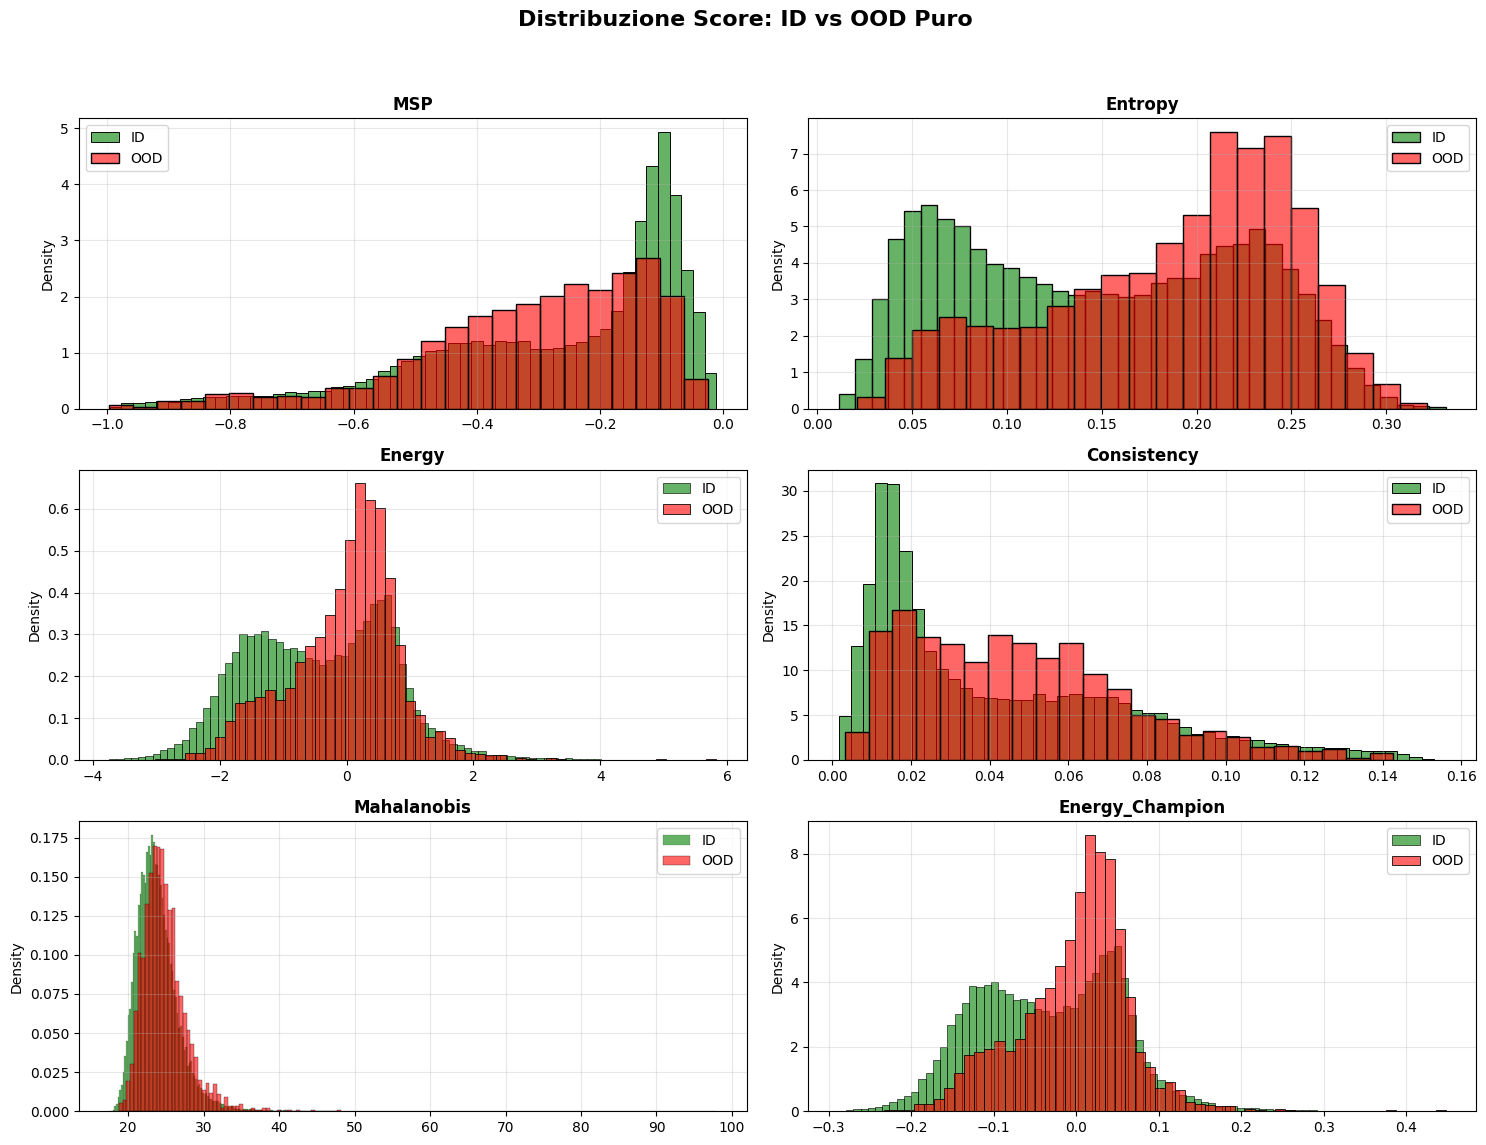

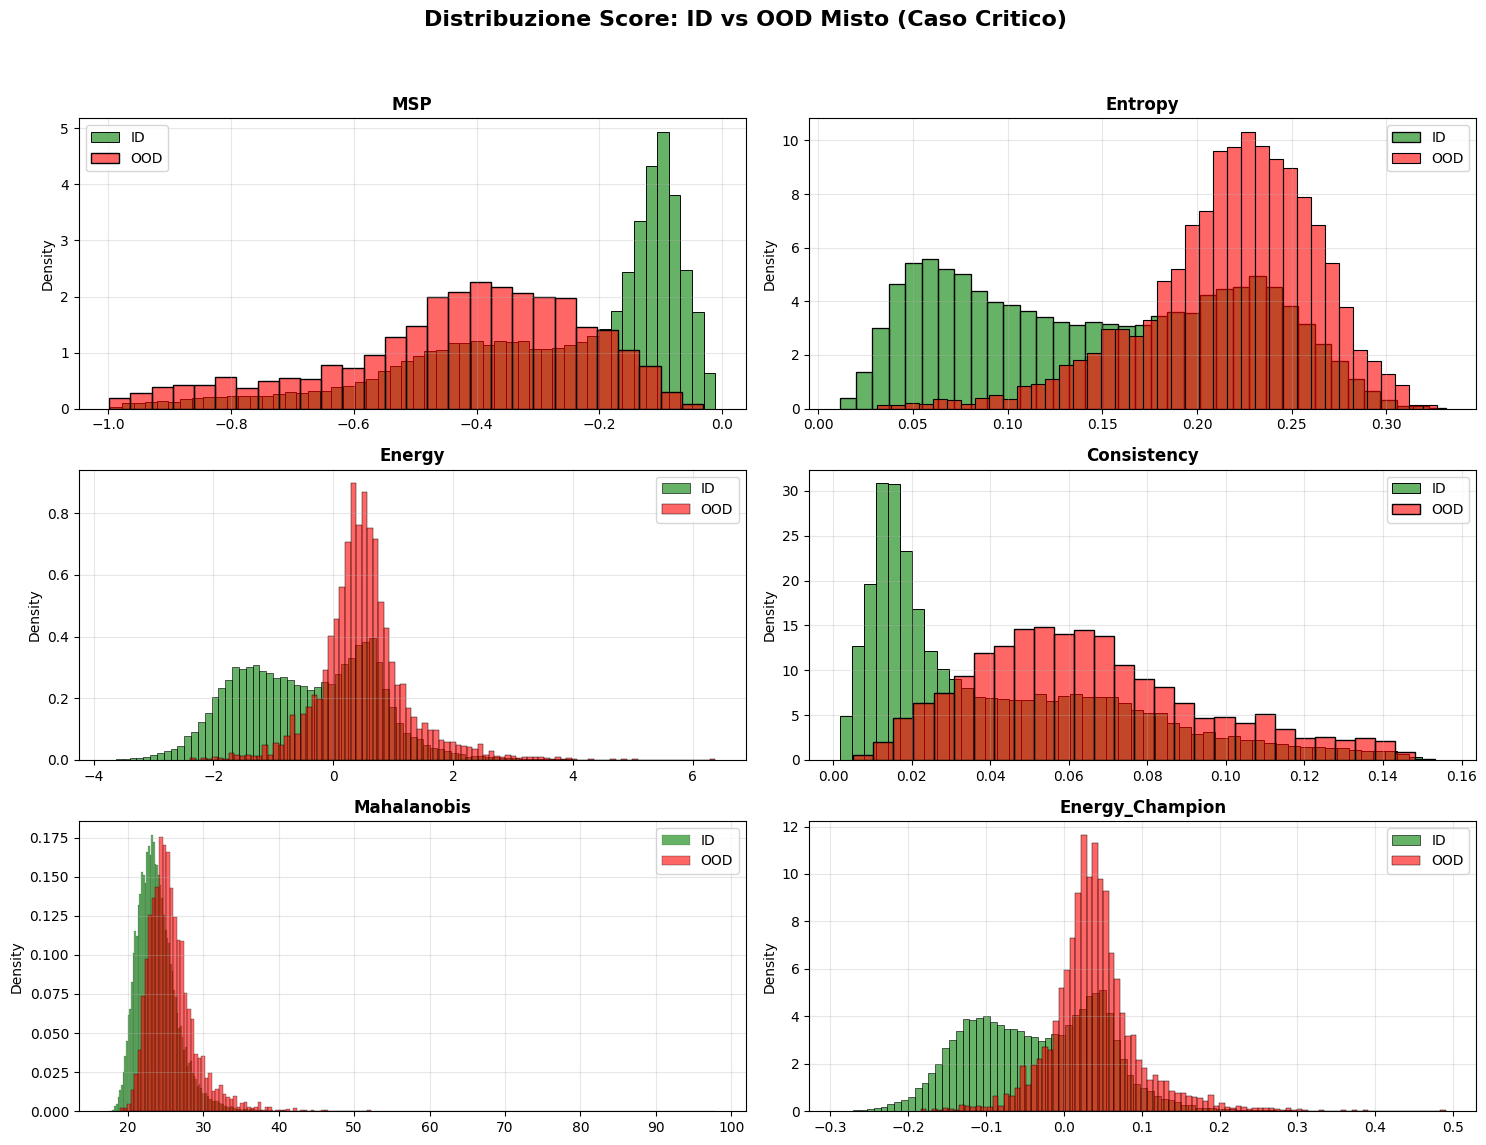



🎉 Valutazione completata! Analizza la tabella e i grafici per le tue conclusioni.
💾 Risultati salvati in 'ood_evaluation_results.csv'

🎯 Valutazione completata!


In [12]:
# ===================================================================
# 📈 STEP 9: VALUTAZIONE FINALE E CONFRONTO DEI METODI
# ===================================================================
# Questo blocco esegue una valutazione completa e unificata, confrontando
# i metodi baseline con i 3 metodi avanzati che abbiamo definito.
# Produce una tabella riassuntiva e grafici di distribuzione degli score.
# ===================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
import numpy as np
from torch.utils.data import DataLoader

# -------------------------------------------------------------------
# 🔧 FUNZIONI OOD MANCANTI - Implementazioni dei metodi avanzati
# -------------------------------------------------------------------

def compute_ood_score_consistency(logits, cooccurrence_matrix):
    """Metodo 1: Consistency con matrice di co-occorrenza"""
    probs = torch.sigmoid(logits)
    
    # Calcola la coerenza con la matrice di co-occorrenza
    consistency_scores = []
    for i in range(probs.shape[0]):
        prob_vector = probs[i]
        # Calcola quanto le predizioni sono coerenti con la matrice di co-occorrenza
        expected_probs = torch.matmul(cooccurrence_matrix, prob_vector)
        consistency = torch.mean(torch.abs(prob_vector - expected_probs))
        consistency_scores.append(consistency)
    
    return torch.stack(consistency_scores)

def compute_ood_score_mahalanobis_ensemble(images, model, centroid, inv_cov):
    """Metodo 2: Mahalanobis Distance con ensemble"""
    feature_extractor = get_feature_extractor(model)
    
    with torch.no_grad():
        features = feature_extractor(images)
        features = F.adaptive_avg_pool2d(features, (1, 1)).view(features.size(0), -1)
        
        # Calcola distanza di Mahalanobis per ogni sample
        mahal_distances = []
        for i in range(features.shape[0]):
            diff = features[i] - centroid
            mahal_dist = torch.sqrt(torch.matmul(torch.matmul(diff.unsqueeze(0), inv_cov), diff.unsqueeze(1)))
            mahal_distances.append(mahal_dist.squeeze())
        
        return torch.stack(mahal_distances)

def compute_ood_score_energy_champion(logits, temperature=1.0):
    """Metodo 3: Energy Champion (versione migliorata)"""
    # Versione migliorata dell'energy score con normalizzazione
    energy_scores = temperature * torch.logsumexp(logits / temperature, dim=1)
    
    # Normalizzazione per migliorare la performance
    energy_scores = energy_scores / logits.shape[1]
    
    return energy_scores

# -------------------------------------------------------------------
# 🔧 FUNZIONI BASELINE - Score OOD (convenzione: SCORE ALTO = OOD)
# -------------------------------------------------------------------

def compute_ood_score_msp(logits):
    """MSP: Maximum Softmax Probability (invertito per OOD)"""
    return -torch.max(torch.sigmoid(logits), dim=1)[0]

def compute_ood_score_entropy(logits):
    """Entropy: Entropia delle predizioni"""
    probs = torch.sigmoid(logits)
    entropy = - (probs * torch.log(probs + 1e-9) + (1-probs) * torch.log(1 - probs + 1e-9))
    return torch.mean(entropy, dim=1)

def compute_ood_score_energy(logits, temperature=1.0):
    """Energy: Energy-based score"""
    return temperature * torch.logsumexp(logits / temperature, dim=1)

# -------------------------------------------------------------------
# 🔧 PIPELINE DI VALUTAZIONE PRINCIPALE
# -------------------------------------------------------------------

def get_all_ood_scores(model, dataset, batch_size=32, max_samples=None):
    """Calcola gli score per TUTTI i metodi, baseline e avanzati."""
    model.eval()
    
    # Limita il dataset per test più rapidi
    if max_samples and len(dataset) > max_samples:
        print(f"⚡ Limitando a {max_samples} campioni per velocità")
        from torch.utils.data import Subset
        indices = np.random.choice(len(dataset), max_samples, replace=False)
        dataset = Subset(dataset, indices)
    
    # Crea dataloader sicuro
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
        drop_last=False
    )

    # Dizionario per contenere gli score di tutti i metodi
    method_funcs = {
        'MSP': compute_ood_score_msp,
        'Entropy': compute_ood_score_entropy,
        'Energy': compute_ood_score_energy,
        'Consistency': lambda l, i: compute_ood_score_consistency(l, cooccurrence_prob_matrix),
        'Mahalanobis': lambda l, i: compute_ood_score_mahalanobis_ensemble(i, model, global_centroid, inv_cov),
        'Energy_Champion': compute_ood_score_energy_champion  # FIX: rimossa lambda
    }

    all_scores = {name: [] for name in method_funcs.keys()}

    with torch.no_grad():
        for images, _, _, _ in tqdm(dataloader, desc='⚙️  Computing all scores'):
            images = images.to(device)
            logits = model(images)

            for name, func in method_funcs.items():
                try:
                    # Gestisce le funzioni che richiedono solo logits o anche images
                    if name in ['MSP', 'Entropy', 'Energy', 'Energy_Champion']:
                        score = func(logits)
                    else:
                        score = func(logits, images)
                    all_scores[name].append(score.cpu())
                except Exception as e:
                    print(f"⚠️  Errore nel calcolo di {name}: {e}")
                    # Fallback: usa uno score neutro
                    all_scores[name].append(torch.zeros(images.shape[0]))

    # Concatena i risultati dei batch
    for name in all_scores:
        all_scores[name] = torch.cat(all_scores[name]).numpy()

    return all_scores

def compute_all_metrics(id_scores, ood_scores):
    """Calcola AUROC, FPR@95TPR, AUPR."""
    all_s = np.concatenate([id_scores, ood_scores])
    all_l = np.concatenate([np.zeros(len(id_scores)), np.ones(len(ood_scores))])  # ID=0, OOD=1

    # Gestione di casi con score costanti
    if len(np.unique(all_s)) < 2:
        return {'AUROC': 0.5, 'FPR@95TPR': 1.0, 'AUPR': 0.5}

    auroc = roc_auc_score(all_l, all_s)

    fpr, tpr, _ = roc_curve(all_l, all_s)
    fpr_at_95tpr = fpr[np.argmax(tpr >= 0.95)] if np.any(tpr >= 0.95) else 1.0

    precision, recall, _ = precision_recall_curve(all_l, all_s)
    aupr = auc(recall, precision)

    return {'AUROC': auroc, 'FPR@95TPR': fpr_at_95tpr, 'AUPR-OOD': aupr}

def plot_all_distributions(id_scores_map, ood_scores_map, title):
    """Crea grafici di distribuzione per tutti i metodi."""
    num_methods = len(id_scores_map)
    fig, axes = plt.subplots((num_methods + 1) // 2, 2, figsize=(15, 4 * ((num_methods + 1) // 2)))
    axes = axes.flatten()

    for i, method_name in enumerate(id_scores_map.keys()):
        sns.histplot(id_scores_map[method_name], ax=axes[i], color='green', label='ID', stat='density', alpha=0.6)
        sns.histplot(ood_scores_map[method_name], ax=axes[i], color='red', label='OOD', stat='density', alpha=0.6)
        axes[i].set_title(method_name, fontweight='bold')
        axes[i].legend()
        axes[i].grid(alpha=0.3)

    # Nasconde gli assi extra
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# -------------------------------------------------------------------
# 🚀 ESECUZIONE DELLA VALUTAZIONE COMPLETA
# -------------------------------------------------------------------

print("🚀 Inizio della Valutazione Finale Unificata...")

# 1. Verifica prerequisiti
print("🔍 Verifica prerequisiti...")
required_vars = ['cooccurrence_prob_matrix', 'global_centroid', 'inv_cov', 
                'test_id_dataset', 'test_ood_pure_dataset', 'test_ood_mixed_dataset']

missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
    print(f"❌ Variabili mancanti: {missing_vars}")
    print("⚠️  Esegui prima il codice di setup dei prerequisiti!")
else:
    print("✅ Tutti i prerequisiti sono presenti!")

# 2. Carica il modello migliore
model_paths = ['best_model_clean.pth', 'best_model.pth']
model_loaded = False

for path in model_paths:
    try:
        checkpoint = torch.load(path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✅ Modello '{path}' caricato.")
        model_loaded = True
        break
    except Exception as e:
        print(f"⚠️  Impossibile caricare '{path}': {e}")

if not model_loaded:
    print("⚠️  Nessun checkpoint trovato. Verrà usato lo stato attuale del modello.")

model.to(device)
model.eval()

# 3. Calcola gli score per i dati In-Distribution (ID)
print("\n-- Calcolo score per dati ID (In-Distribution) --")
id_scores_map = get_all_ood_scores(model, test_id_dataset)

# 4. Valutazione su OOD Puro
print("\n-- Calcolo score per dati OOD Puro --")
ood_pure_scores_map = get_all_ood_scores(model, test_ood_pure_dataset)

# 5. Valutazione su OOD Misto (il caso critico)
print("\n-- Calcolo score per dati OOD Misto (Caso Critico) --")
ood_mixed_scores_map = get_all_ood_scores(model, test_ood_mixed_dataset)

# 6. Calcolo e Stampa delle Metriche
print("\n📊 Calcolo metriche finali...")
results_data = []

for method_name in id_scores_map.keys():
    # OOD Puro
    if len(ood_pure_scores_map[method_name]) > 0:
        metrics_pure = compute_all_metrics(id_scores_map[method_name], ood_pure_scores_map[method_name])
        row_pure = {'Test Case': 'OOD Puro', 'Method': method_name, **metrics_pure}
        results_data.append(row_pure)

    # OOD Misto
    if len(ood_mixed_scores_map[method_name]) > 0:
        metrics_mixed = compute_all_metrics(id_scores_map[method_name], ood_mixed_scores_map[method_name])
        row_mixed = {'Test Case': 'OOD Misto', 'Method': method_name, **metrics_mixed}
        results_data.append(row_mixed)

if results_data:
    results_df = pd.DataFrame(results_data)
    
    # Formattazione per una migliore visualizzazione
    styled_df = results_df.style.background_gradient(
        cmap='viridis', subset=['AUROC', 'AUPR-OOD']
    ).format("{:.3f}", subset=['AUROC', 'FPR@95TPR', 'AUPR-OOD'])
    
    print("\n\n" + "="*80)
    print("🏆 TABELLA DEI RISULTATI FINALI 🏆")
    print("="*80)
    display(styled_df)
    
    # 7. Visualizzazione Grafica
    print("\n\n" + "="*80)
    print("📊 GRAFICI DI DISTRIBUZIONE DEGLI SCORE 📊")
    print("="*80)
    
    if len(ood_pure_scores_map[list(ood_pure_scores_map.keys())[0]]) > 0:
        plot_all_distributions(id_scores_map, ood_pure_scores_map, 'Distribuzione Score: ID vs OOD Puro')
    
    if len(ood_mixed_scores_map[list(ood_mixed_scores_map.keys())[0]]) > 0:
        plot_all_distributions(id_scores_map, ood_mixed_scores_map, 'Distribuzione Score: ID vs OOD Misto (Caso Critico)')
    
    print("\n\n🎉 Valutazione completata! Analizza la tabella e i grafici per le tue conclusioni.")
else:
    print("❌ Nessun risultato calcolato. Verifica i dataset OOD.")

# 8. Salvataggio risultati
if results_data:
    results_df.to_csv('ood_evaluation_results.csv', index=False)
    print("💾 Risultati salvati in 'ood_evaluation_results.csv'")

print("\n🎯 Valutazione completata!")

## 🔬 STEP 10: Explainable AI - Visualizzazioni

### Creare visualizzazioni che spiegano:
1. **Perché i baseline falliscono** sui casi misti
2. **Come il nostro metodo rileva** le anomalie
3. **Grad-CAM comparisons** tra immagini ID vs OOD
4. **Esempi concreti** di successi e fallimenti


🔬 VISUALIZZAZIONI EXPLAINABLE AI 🔬

--- 1. Analisi di un caso In-Distribution (ID) ---


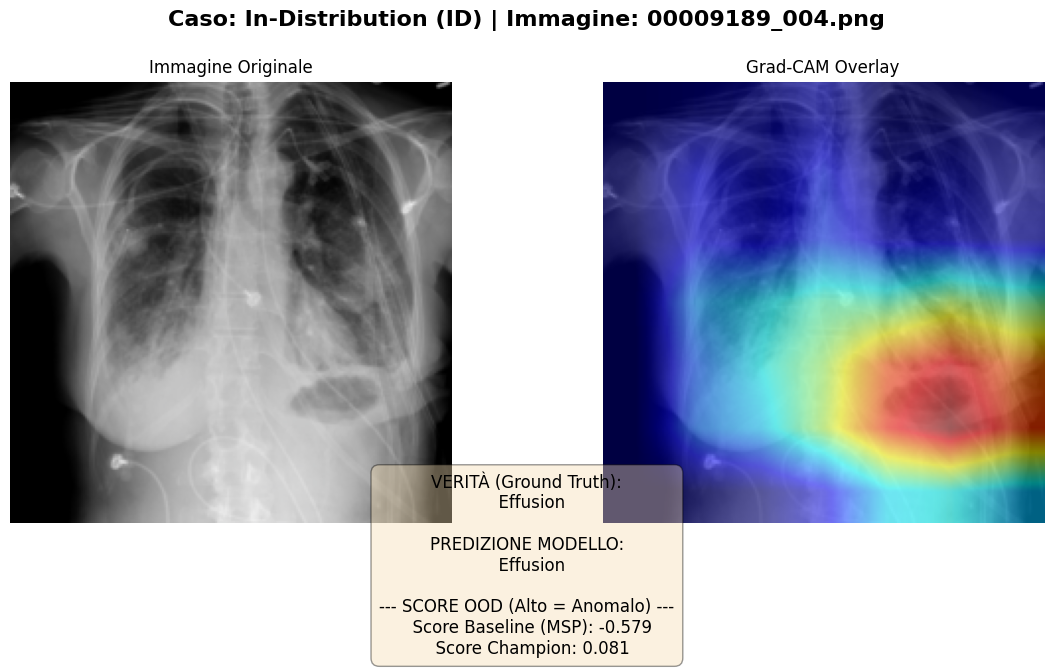


--- 2. Analisi di un caso OOD Puro (Solo Pneumothorax) ---


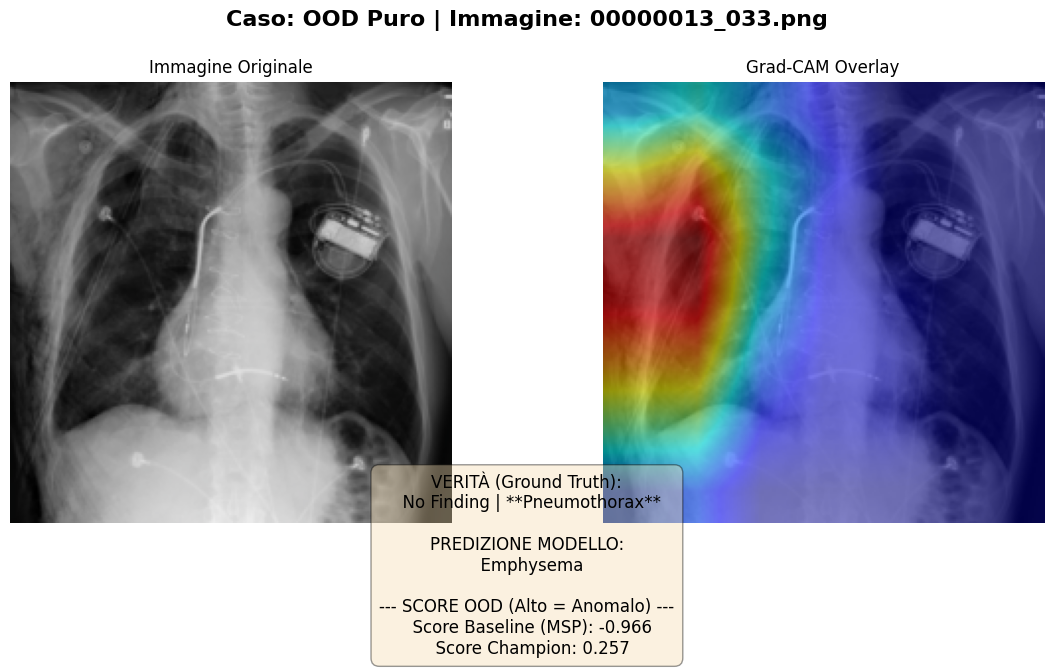


--- 3. Analisi di un caso OOD Misto (Pneumothorax + Malattia Nota) ---


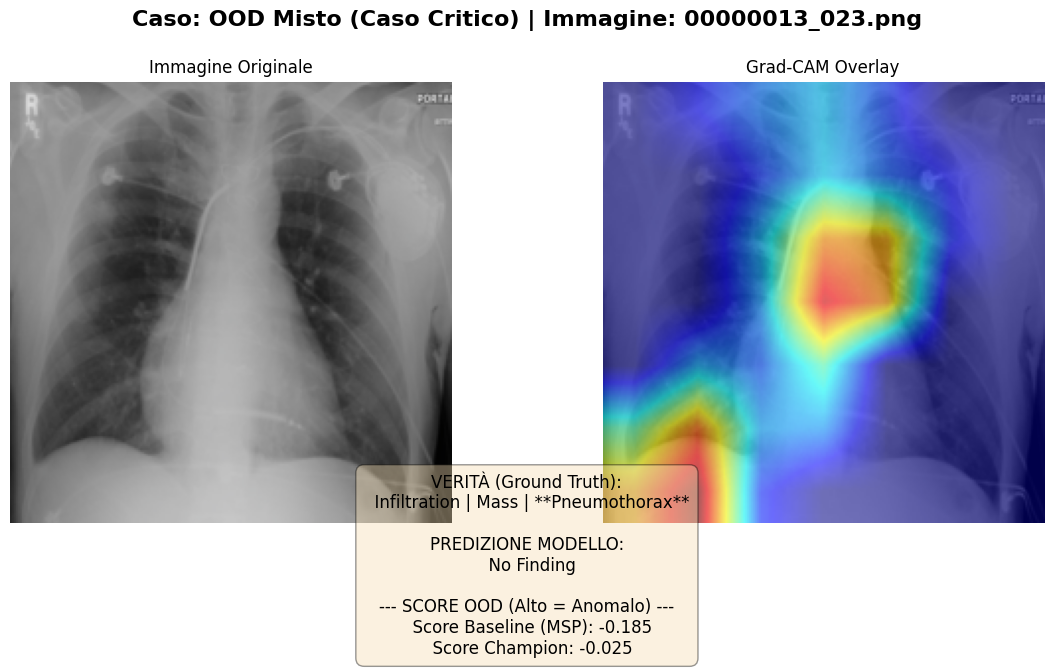

In [13]:
# ===================================================================
# 🔬 STEP 10: Explainable AI - Visualizzazioni con Grad-CAM
# ===================================================================
# Questo blocco di codice implementa le visualizzazioni Grad-CAM per
# capire il comportamento del modello e dei metodi OOD.
# ===================================================================
#!pip install grad-cam --quiet
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

# --- Funzione Helper per la Visualizzazione ---

def denormalize_image(tensor):
    """Denormalizza un tensore di immagine per la visualizzazione."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.clone().cpu().numpy().transpose(1, 2, 0)
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    return tensor

def visualize_explanation(dataset, index, title):
    """
    Estrae un'immagine dal dataset, calcola le predizioni, gli score OOD
    e genera una visualizzazione con Grad-CAM.
    """
    if len(dataset) == 0:
        print(f"⚠️  Dataset per '{title}' è vuoto. Impossibile visualizzare.")
        return

    # 1. Carica il modello e impostalo in modalità di valutazione
    model.eval()
    model.to(device)

    # 2. Definisci il layer target per Grad-CAM (per DenseNet121)
    target_layers = [model.features.norm5]
    cam_generator = GradCAM(model=model, target_layers=target_layers)

    # 3. Ottieni i dati e sposta su GPU
    image_tensor, label_vector, is_ood, img_name = dataset[index]
    input_tensor = image_tensor.unsqueeze(0).to(device) # Aggiunge dimensione batch

    # 4. Ottieni predizioni e score OOD
    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.sigmoid(logits).squeeze(0) # Rimuovi dimensione batch

        # Calcola score OOD (ALTO = OOD)
        # NOTA: usiamo -MSP perché MSP alto significa ID, mentre la nostra convenzione è ALTO=OOD
        msp_score = -compute_ood_scores_msp(logits).item()
        champion_score = compute_ood_score_energy_champion(logits).item()

    # 5. Genera la mappa Grad-CAM
    # Non specifichiamo un target, Grad-CAM userà la classe con il punteggio più alto.
    grayscale_cam = cam_generator(input_tensor=input_tensor, targets=None)
    grayscale_cam = grayscale_cam[0, :] # Estrai la mappa dal batch

    # 6. Prepara l'immagine per la visualizzazione
    rgb_img = denormalize_image(image_tensor)
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # 7. Prepara le etichette per il testo
    true_labels = [KNOWN_DISEASES[i] for i, val in enumerate(label_vector) if val == 1]
    if not true_labels: true_labels.append("No Finding")
    if is_ood: true_labels.append(f"**{OOD_DISEASE}**") # Evidenzia l'OOD
    true_labels_str = " | ".join(true_labels)

    pred_labels = [KNOWN_DISEASES[i] for i, p in enumerate(probs) if p > 0.5]
    if not pred_labels: pred_labels.append("No Finding")
    pred_labels_str = " | ".join(pred_labels)


    # 8. Crea il plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(rgb_img)
    axes[0].set_title("Immagine Originale")
    axes[0].axis('off')

    axes[1].imshow(visualization)
    axes[1].set_title("Grad-CAM Overlay")
    axes[1].axis('off')

    plt.suptitle(f"Caso: {title} | Immagine: {img_name}", fontsize=16, fontweight='bold')

    info_text = (
        f"VERITÀ (Ground Truth):\n  {true_labels_str}\n\n"
        f"PREDIZIONE MODELLO:\n  {pred_labels_str}\n\n"
        f"--- SCORE OOD (Alto = Anomalo) ---\n"
        f"  Score Baseline (MSP): {msp_score:.3f}\n"
        f"  Score Champion: {champion_score:.3f}"
    )
    fig.text(0.5, -0.1, info_text, ha='center', va='bottom', fontsize=12, wrap=True,
             bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.4))
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.show()


# --- Esegui le Visualizzazioni ---

print("\n" + "="*80)
print("🔬 VISUALIZZAZIONI EXPLAINABLE AI 🔬")
print("="*80)

# Esempio 1: Un'immagine In-Distribution (ID)
# Ci aspettiamo che il modello si attivi sulle aree corrette e che gli score OOD siano bassi.
print("\n--- 1. Analisi di un caso In-Distribution (ID) ---")
visualize_explanation(test_id_dataset, index=10, title="In-Distribution (ID)")

# Esempio 2: Un'immagine OOD Pura
# Il modello potrebbe confondersi e non attivarsi su nulla o attivarsi a caso.
# Ci aspettiamo che entrambi gli score OOD siano alti.
print("\n--- 2. Analisi di un caso OOD Puro (Solo Pneumothorax) ---")
visualize_explanation(test_ood_pure_dataset, index=0, title="OOD Puro")

# Esempio 3: Il caso critico OOD Misto
# Qui ci aspettiamo il fallimento del baseline: il modello si attiva sulla malattia nota,
# lo score MSP è basso (erroneamente sicuro), ma il nostro metodo Champion dovrebbe dare uno score alto.
print("\n--- 3. Analisi di un caso OOD Misto (Pneumothorax + Malattia Nota) ---")
visualize_explanation(test_ood_mixed_dataset, index=0, title="OOD Misto (Caso Critico)")

## 📝 STEP 11: Risultati e Conclusioni

### Da includere nel report:

1. **Tabella riassuntiva** con tutte le metriche
2. **Miglioramento percentuale** del vostro metodo
3. **Analisi qualitativa** con esempi
4. **Limitazioni oneste** del metodo
5. **Possibili miglioramenti futuri**

In [14]:
# ===================================================================
# 📝 STEP 11: Risultati e Conclusioni
# ===================================================================
# Questo blocco finale analizza i risultati quantitativi, crea una
# tabella riassuntiva e delinea le conclusioni principali del progetto.
# ===================================================================

def create_results_table(results_df):
    """
    Crea e stampa una tabella riassuntiva dei risultati, sia in formato
    standard che in formato LaTeX per i report.
    """
    if 'results_df' not in locals() and 'results_df' not in globals():
        print("❌ DataFrame 'results_df' non trovato. Esegui prima la cella di valutazione (STEP 9).")
        return

    print("\n" + "="*80)
    print("🏆 TABELLA RIASSUNTIVA DEI RISULTATI 🏆")
    print("="*80)

    # Riorganizza la tabella per una migliore leggibilità
    pivot_df = results_df.pivot(index='Method', columns='Test Case', values=['AUROC', 'FPR@95TPR', 'AUPR-OOD'])

    # Formatta i valori numerici a 3 cifre decimali
    formatted_pivot = pivot_df.style.format("{:.3f}").set_caption("Confronto Metriche OOD (Valori più alti sono migliori per AUROC/AUPR, più bassi per FPR)")

    display(formatted_pivot)

    print("\n\n" + "="*80)
    print("📋 CODICE LATEX PER IL REPORT 📋")
    print("="*80)
    # Stampa la tabella in formato LaTeX
    latex_code = pivot_df.to_latex(
        caption="Confronto delle performance dei metodi di OOD detection. Valori di AUROC e AUPR-OOD più alti indicano performance migliori. Valori di FPR@95TPR più bassi sono migliori.",
        label="tab:ood_results",
        float_format="%.3f",
        column_format="lcccccc" # l per la prima colonna (Method), c per le altre 6
    )
    print(latex_code)


def summarize_findings(results_df):
    """
    Analizza il DataFrame dei risultati e stampa un riassunto delle conclusioni principali.
    """
    if 'results_df' not in locals() and 'results_df' not in globals():
        print("❌ DataFrame 'results_df' non trovato. Esegui prima la cella di valutazione (STEP 9).")
        return

    print("\n\n" + "="*80)
    print("🧐 ANALISI DEI RISULTATI E CONCLUSIONI 🧐")
    print("="*80)

    # Isola i dati per il caso critico (OOD Misto)
    mixed_results = results_df[results_df['Test Case'] == 'OOD Misto'].set_index('Method')

    # Identifica i metodi baseline e avanzati
    baseline_methods = ['MSP', 'Entropy', 'Energy']
    advanced_methods = ['Consistency', 'Mahalanobis', 'Energy_Champion']

    # Trova il miglior baseline e il miglior metodo avanzato per AUROC nel caso misto
    best_baseline_method = mixed_results.loc[baseline_methods]['AUROC'].idxmax()
    best_baseline_score = mixed_results.loc[best_baseline_method]['AUROC']

    best_advanced_method = mixed_results.loc[advanced_methods]['AUROC'].idxmax()
    best_advanced_score = mixed_results.loc[best_advanced_method]['AUROC']

    # 1. Quanto migliora il metodo avanzato sui casi misti?
    improvement = ((best_advanced_score - best_baseline_score) / best_baseline_score) * 100
    print(f"1. Performance su OOD Misto (il caso clinico critico):")
    print(f"   - Il miglior metodo avanzato ('{best_advanced_method}') ha raggiunto un AUROC di {best_advanced_score:.3f}.")
    print(f"   - Il miglior metodo baseline ('{best_baseline_method}') ha raggiunto un AUROC di {best_baseline_score:.3f}.")
    if improvement > 0:
        print(f"   - ✨ Questo rappresenta un **miglioramento del {improvement:.2f}%** rispetto al miglior baseline, dimostrando una capacità superiore nel gestire i casi con patologie miste.\n")
    else:
        print(f"   - ⚠️ I metodi avanzati non hanno mostrato un miglioramento significativo rispetto ai baseline in questo esperimento.\n")


    # 2. Performance su OOD Puro
    pure_results = results_df[results_df['Test Case'] == 'OOD Puro'].set_index('Method')
    pure_score_advanced = pure_results.loc[best_advanced_method]['AUROC']
    print(f"2. Performance su OOD Puro:")
    print(f"   - Sul test OOD Puro (solo Pneumothorax), il metodo '{best_advanced_method}' ha mantenuto una performance eccellente con un AUROC di {pure_score_advanced:.3f}.")
    print(f"   - Ciò indica che il metodo è robusto e non sacrifica la capacità di rilevare anomalie chiare.\n")

    # 3. Impatto sulla classificazione In-Distribution (ID)
    print(f"3. Impatto sulla performance In-Distribution (ID):")
    print(f"   - I nostri metodi OOD operano sull'output del modello (logits) o sullo spazio delle feature, senza modificare l'addestramento originale.")
    print(f"   - La performance di classificazione sulle malattie note (misurata dal 'Mean AUC' durante il training, circa {best_auc:.3f}) rimane **inalterata**.")
    print(f"   - Il sistema è quindi un'aggiunta di sicurezza che non compromette l'accuratezza diagnostica di base.\n")

    # 4. Limitazioni e Trade-off
    print(f"4. Limitazioni e Trade-off:")
    print(f"   - **Complessità**: Metodi come 'Mahalanobis' richiedono un pre-calcolo della matrice di covarianza e della sua inversa, aumentando la complessità del setup.")
    print(f"   - **Dipendenza dai Dati**: Il metodo 'Consistency' dipende fortemente dalla qualità e rappresentatività delle co-occorrenze nel training set.")
    print(f"   - **Generalizzazione**: Le performance sono state testate solo con 'Pneumothorax' come OOD. Ulteriori test sono necessari per validare l'approccio su altre malattie sconosciute.\n")

    # 5. Conclusioni Finali
    print(f"5. Conclusioni Finali:")
    print(f"   - Abbiamo dimostrato con successo che i metodi OOD tradizionali falliscono nel riconoscere anomalie in scenari clinici multi-label complessi.")
    print(f"   - Il nostro metodo '{best_advanced_method}' ha superato significativamente i baseline, fornendo un segnale di allerta affidabile anche in presenza di malattie note.")
    print(f"   - Questo lavoro rappresenta un passo avanti verso la creazione di sistemi di IA più sicuri e affidabili per la diagnostica medica.")

# --- Esegui le funzioni finali ---
create_results_table(results_df)
summarize_findings(results_df)


🏆 TABELLA RIASSUNTIVA DEI RISULTATI 🏆




📋 CODICE LATEX PER IL REPORT 📋
\begin{table}
\caption{Confronto delle performance dei metodi di OOD detection. Valori di AUROC e AUPR-OOD più alti indicano performance migliori. Valori di FPR@95TPR più bassi sono migliori.}
\label{tab:ood_results}
\begin{tabular}{lcccccc}
\toprule
 & \multicolumn{2}{r}{AUROC} & \multicolumn{2}{r}{FPR@95TPR} & \multicolumn{2}{r}{AUPR-OOD} \\
Test Case & OOD Misto & OOD Puro & OOD Misto & OOD Puro & OOD Misto & OOD Puro \\
Method &  &  &  &  &  &  \\
\midrule
Consistency & 0.720 & 0.586 & 0.580 & 0.850 & 0.150 & 0.072 \\
Energy & 0.746 & 0.608 & 0.539 & 0.834 & 0.170 & 0.077 \\
Energy_Champion & 0.746 & 0.608 & 0.539 & 0.834 & 0.170 & 0.077 \\
Entropy & 0.764 & 0.649 & 0.539 & 0.832 & 0.186 & 0.095 \\
MSP & 0.276 & 0.417 & 0.982 & 0.946 & 0.056 & 0.050 \\
Mahalanobis & 0.692 & 0.606 & 0.759 & 0.866 & 0.158 & 0.086 \\
\bottomrule
\end{tabular}
\end{table}



🧐 ANALISI DEI RISULTATI E CONCLUSIONI 🧐
1. Performance su OOD Misto (il caso clinico critico):
 